# Antonin DOAT (student number : 932151480)

#Library Imports and creation of the spark App

Importing the necessary libraries

In [1]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [2]:
!pip install yfinance mplfinance

In [3]:
!python --version

Python 3.10.12


Importing all the library

In [4]:
from pyspark.sql import SparkSession
import pandas as pd
import yfinance as yf
from pyspark.sql.functions import *
from pyspark.sql import Window
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import plotly.graph_objects as go
import mplfinance as mpf
from IPython.display import display, clear_output

Creating the Python application

In [5]:
nasdaq_app = "Nasdaq_tech_stocks "

In [6]:
spark = (SparkSession.builder.config("spark.driver.memory", "15g").appName(nasdaq_app).getOrCreate())

Selecting the symbols we want to use

In [7]:
# Defining the stock symbols to analyze
symbols = ["AAPL", "MSFT", "AMZN","META","ZM"]

# Quick Exploration

First of all, to begin the project, we have to load the dataset.

To do so, we use the yfinance library. In this code, we also load each dataframe another time and convert it in a csv file in order to use in the insight.

In [8]:
def download_dataset(symbol, start_date, end_date):

    # This function takes a stock symbol and a date range (start and end dates) to download historical data

    # Load the stock data into a pandas DataFrame using yfinance
    panda_df = yf.download(symbol, start=start_date, end=end_date)
    panda_df.reset_index(inplace=True)

    #for the last question about the interactive insight
    for symbols in symbol:
      df_for_each = yf.download(symbols, start=start_date, end=end_date)
      df_for_each.reset_index(inplace=True)
      df_for_each.to_csv(f"{symbols}.csv")

    # Convert the pandas DataFrame into a Spark DataFrame
    spark_df = spark.createDataFrame(panda_df)
    return spark_df

df = download_dataset(symbols, "2001-01-01", "2024-12-31")

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


After the loading, let'scheck for the dataset schema.

In [9]:
df.printSchema()

root
 |-- ('Date', ''): timestamp (nullable = true)
 |-- ('Adj Close', 'AAPL'): double (nullable = true)
 |-- ('Adj Close', 'AMZN'): double (nullable = true)
 |-- ('Adj Close', 'META'): double (nullable = true)
 |-- ('Adj Close', 'MSFT'): double (nullable = true)
 |-- ('Adj Close', 'ZM'): double (nullable = true)
 |-- ('Close', 'AAPL'): double (nullable = true)
 |-- ('Close', 'AMZN'): double (nullable = true)
 |-- ('Close', 'META'): double (nullable = true)
 |-- ('Close', 'MSFT'): double (nullable = true)
 |-- ('Close', 'ZM'): double (nullable = true)
 |-- ('High', 'AAPL'): double (nullable = true)
 |-- ('High', 'AMZN'): double (nullable = true)
 |-- ('High', 'META'): double (nullable = true)
 |-- ('High', 'MSFT'): double (nullable = true)
 |-- ('High', 'ZM'): double (nullable = true)
 |-- ('Low', 'AAPL'): double (nullable = true)
 |-- ('Low', 'AMZN'): double (nullable = true)
 |-- ('Low', 'META'): double (nullable = true)
 |-- ('Low', 'MSFT'): double (nullable = true)
 |-- ('Low', 'ZM

In [10]:
df.columns

["('Date', '')",
 "('Adj Close', 'AAPL')",
 "('Adj Close', 'AMZN')",
 "('Adj Close', 'META')",
 "('Adj Close', 'MSFT')",
 "('Adj Close', 'ZM')",
 "('Close', 'AAPL')",
 "('Close', 'AMZN')",
 "('Close', 'META')",
 "('Close', 'MSFT')",
 "('Close', 'ZM')",
 "('High', 'AAPL')",
 "('High', 'AMZN')",
 "('High', 'META')",
 "('High', 'MSFT')",
 "('High', 'ZM')",
 "('Low', 'AAPL')",
 "('Low', 'AMZN')",
 "('Low', 'META')",
 "('Low', 'MSFT')",
 "('Low', 'ZM')",
 "('Open', 'AAPL')",
 "('Open', 'AMZN')",
 "('Open', 'META')",
 "('Open', 'MSFT')",
 "('Open', 'ZM')",
 "('Volume', 'AAPL')",
 "('Volume', 'AMZN')",
 "('Volume', 'META')",
 "('Volume', 'MSFT')",
 "('Volume', 'ZM')"]

# Pre-processing

We can see that in the schema, the columns name are not very good and the date in not in the correct type, so let's clean the dataset to simplify the dataframe.To do that, we replace the columns name by simpler one and convert the Date column to a date format.

In [11]:
def rename_columns(df):

    for col in df.columns:
        # Retain "Date" column as is and simplify the other column names
        if col == "('Date', '')":
            df = df.withColumnRenamed(col, "Date")

        # Replace special characters and remove spaces
        else:
            new_col_name = (
                col.replace("(", "")
                   .replace(")", "")
                   .replace("'", "")
                   .replace(", ", "_")
                   .replace(" ", "_")
            )
            df = df.withColumnRenamed(col, new_col_name)

    # Convert the "Date" column to a date format
    df = df.withColumn("Date", to_date("Date"))
    df.show()
    df.printSchema()
    return df

spark_df = rename_columns(df)



+----------+-------------------+------------------+--------------+------------------+------------+-------------------+------------------+----------+----------+--------+-------------------+------------------+---------+---------+-------+-------------------+------------------+--------+--------+------+-------------------+------------------+---------+---------+-------+-----------+-----------+-----------+-----------+---------+
|      Date|     Adj_Close_AAPL|    Adj_Close_AMZN|Adj_Close_META|    Adj_Close_MSFT|Adj_Close_ZM|         Close_AAPL|        Close_AMZN|Close_META|Close_MSFT|Close_ZM|          High_AAPL|         High_AMZN|High_META|High_MSFT|High_ZM|           Low_AAPL|          Low_AMZN|Low_META|Low_MSFT|Low_ZM|          Open_AAPL|         Open_AMZN|Open_META|Open_MSFT|Open_ZM|Volume_AAPL|Volume_AMZN|Volume_META|Volume_MSFT|Volume_ZM|
+----------+-------------------+------------------+--------------+------------------+------------+-------------------+------------------+----------+--

In [12]:
spark_df.columns

['Date',
 'Adj_Close_AAPL',
 'Adj_Close_AMZN',
 'Adj_Close_META',
 'Adj_Close_MSFT',
 'Adj_Close_ZM',
 'Close_AAPL',
 'Close_AMZN',
 'Close_META',
 'Close_MSFT',
 'Close_ZM',
 'High_AAPL',
 'High_AMZN',
 'High_META',
 'High_MSFT',
 'High_ZM',
 'Low_AAPL',
 'Low_AMZN',
 'Low_META',
 'Low_MSFT',
 'Low_ZM',
 'Open_AAPL',
 'Open_AMZN',
 'Open_META',
 'Open_MSFT',
 'Open_ZM',
 'Volume_AAPL',
 'Volume_AMZN',
 'Volume_META',
 'Volume_MSFT',
 'Volume_ZM']

In this function, we replace all the NaN values by None which will allows us later to do some statitstics and simplify our calcul.

This function, cleaning, processes a Spark DataFrame by replacing "NaN" values with None and converting all other values (except the Date column) to the float type. It iterates over each column, applies the transformation, and displays the resulting DataFrame and its schema. The cleaned DataFrame is then saved as a CSV file for further analysis.

In [13]:
def cleaning(df):
    for colu in df.columns:
        if colu == "Date":
            continue
        # Remplacer "NaN" (valeur float) par None et convertir les autres valeurs en float
        df = df.withColumn(colu,
                           when(col(colu) == "NaN", None)
                            .otherwise(col(colu).cast("float")))
    df.show()
    df.printSchema()
    return df

# Appel de la fonction de nettoyage
spark_df = cleaning(spark_df)

#for the insight
spark_df.toPandas().to_csv("cleaned_df.csv")


+----------+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+--------+------+---------+---------+---------+---------+-------+------------+------------+-----------+------------+---------+
|      Date|Adj_Close_AAPL|Adj_Close_AMZN|Adj_Close_META|Adj_Close_MSFT|Adj_Close_ZM|Close_AAPL|Close_AMZN|Close_META|Close_MSFT|Close_ZM|High_AAPL|High_AMZN|High_META|High_MSFT|High_ZM|Low_AAPL|Low_AMZN|Low_META|Low_MSFT|Low_ZM|Open_AAPL|Open_AMZN|Open_META|Open_MSFT|Open_ZM| Volume_AAPL| Volume_AMZN|Volume_META| Volume_MSFT|Volume_ZM|
+----------+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+--------+------+---------+---------+---------+---------+-------+------------+------------+-----------+-------

Once the dataframe is clean we can't start explorating the data.

#Quick Data Exploration and Analysis


Show the first and last 40 rows of each stock price

In this function we want to display the first and last 40 rows. For the first 40 rows, we just use the show function. Howerver, for the last 40 rows there is no function that directly show the last rows, we have to order the dataframe in descending order and then use the show function.

In [14]:
def show_first_last_rows(df, num_rows):
    # Show first "num_rows" rows
    print(f"First {num_rows} rows:")
    df.show(num_rows)

    # Show last "num_rows" rows
    print(f"\nLast {num_rows} rows:")
    df.orderBy("Date", ascending=False).show(num_rows)

show_first_last_rows(spark_df, 40)

First 40 rows:
+----------+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+---------+------+---------+---------+---------+---------+-------+------------+------------+-----------+------------+---------+
|      Date|Adj_Close_AAPL|Adj_Close_AMZN|Adj_Close_META|Adj_Close_MSFT|Adj_Close_ZM|Close_AAPL|Close_AMZN|Close_META|Close_MSFT|Close_ZM|High_AAPL|High_AMZN|High_META|High_MSFT|High_ZM|Low_AAPL|Low_AMZN|Low_META| Low_MSFT|Low_ZM|Open_AAPL|Open_AMZN|Open_META|Open_MSFT|Open_ZM| Volume_AAPL| Volume_AMZN|Volume_META| Volume_MSFT|Volume_ZM|
+----------+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+---------+------+---------+---------+---------+---------+-------+------------+------------+-

In order to know how are datas evolves throw the time, we can plot their evolutions.

Let's create a function that display a column that the user enter in parameter.

This function, `plot_col`, visualizes the evolution of a specified column (e.g., "Open") for multiple symbols in a Spark DataFrame. It first converts the Spark DataFrame to a Pandas DataFrame, constructs dynamic column names based on the provided symbols, and plots the data against the `Date` column. The plot is customized with titles, labels, and legends for better readability.

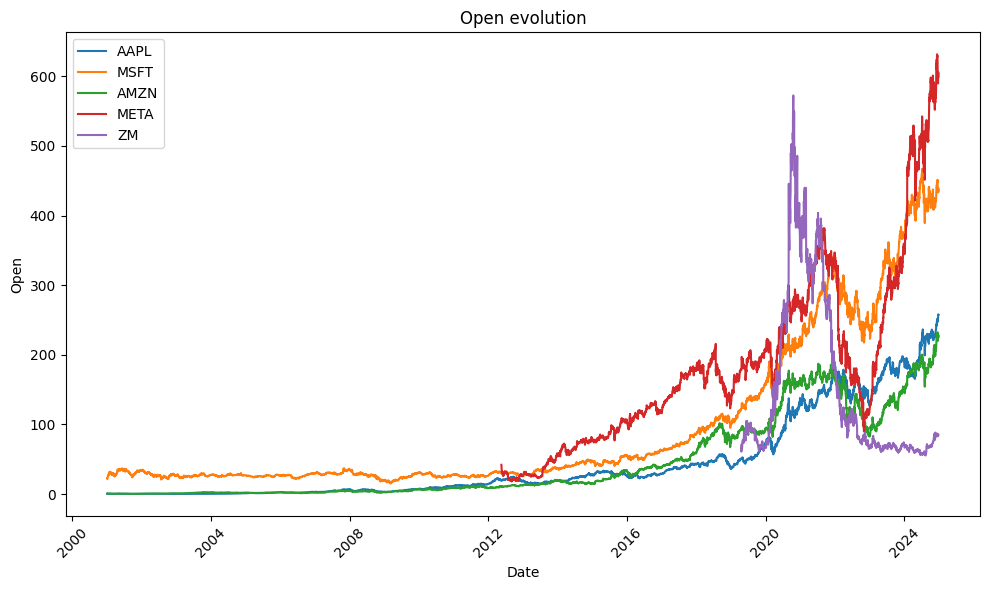

In [15]:
def plot_col(colu_name,spark_df,symbols):
  spark_df_pandas = spark_df.toPandas()
  plt.figure(figsize=(10, 6))
  for sym in symbols:
    column_name = f"{colu_name}_{sym}"
    if column_name in spark_df_pandas.columns:
       plt.plot(spark_df_pandas['Date'], spark_df_pandas[column_name], label=sym)
    else:
       print(f"Column {column_name} not found in DataFrame!")

  plt.title(f'{colu_name} evolution')
  plt.xlabel('Date')
  plt.ylabel(f'{colu_name}')
  plt.legend()

  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

plot_col("Open",spark_df, symbols)

Get the number of observations

In order to have an idea of how many lines we are dealing with we can create a function that return the number of observation.

In [16]:
def get_number_of_observations(df):
    #use of the count function
    return df.count()
print("The number of observations is :",get_number_of_observations(spark_df))

The number of observations is : 6035


Deduce programmatically what is the period you have between the data points : for
example, if you have data point with the following date [01/01, 02/01, .....], you
should have a function that will analyse the difference between the dates
automatically and deduce it is a day period



This function, deduce_period, determines the frequency of a dataset based on the differences between consecutive dates. It uses the lag function to compute previous dates and calculates the differences in days. The mean of these differences is compared against thresholds to classify the period as daily, monthly, yearly, or return the mean difference if it doesn't match predefined ranges. Finally, the function prints the identified period for the DataFrame.

In [17]:
def deduce_period(diff_df):
      # Define a window specification ordered by the "Date" column
      window_spec = Window.orderBy("Date")

      # Apply the lag function to get the previous date
      # The lag function takes the "Date" column and shifts it by 1 row (1 previous date)
      diff_df = diff_df.withColumn("Prev_Date", lag("Date", 1).over(window_spec))

      # Calculate the difference between the current date and the previous date
      # datediff returns the difference in days between two dates
      diff_df = diff_df.withColumn("Date_Diff", (datediff(diff_df["Date"], diff_df["Prev_Date"])))

      # Calculate the mean of the date differences
      mean_diff = diff_df.select(mean("Date_Diff")).first()[0]

      if 0.5 < mean_diff < 1.5:
          period = "daily"
      elif 27 < mean_diff < 31:
          period = "monthly"
      elif 360 < mean_diff < 370:
          period = "yearly"
      else:
          period = mean_diff
      return period


print("This dataframe is a", deduce_period(spark_df), "period")


This dataframe is a daily period


Number of missing values for each dataframe and column

This function, count_nulls, calculates the number of null values in each column of a Spark DataFrame, excluding specific columns like Date. It iterates through the columns, applies a conditional check for null values, and aggregates the counts. The results are displayed  and the DataFrame with null counts is returned for further analysis.

In [18]:
def count_nulls(df):
    # Ignore the 'Date' column
    columns_to_ignore = ['Date']

    # Initialize an empty list to store the count results
    null_counts_list = []

    for col_name in df.columns:
        # Skip the columns listed in columns_to_ignore
        if col_name not in columns_to_ignore:
            # Count the Nulls in each column, excluding the ones to ignore
            null_count = sum(when(col(col_name).isNull(), 1).otherwise(0)).alias(col_name)
            null_counts_list.append(null_count)

    # Select the results and display them
    null_counts = df.select(null_counts_list)
    null_counts.show()

    return null_counts

count_nulls(spark_df)


+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+--------+------+---------+---------+---------+---------+-------+-----------+-----------+-----------+-----------+---------+
|Adj_Close_AAPL|Adj_Close_AMZN|Adj_Close_META|Adj_Close_MSFT|Adj_Close_ZM|Close_AAPL|Close_AMZN|Close_META|Close_MSFT|Close_ZM|High_AAPL|High_AMZN|High_META|High_MSFT|High_ZM|Low_AAPL|Low_AMZN|Low_META|Low_MSFT|Low_ZM|Open_AAPL|Open_AMZN|Open_META|Open_MSFT|Open_ZM|Volume_AAPL|Volume_AMZN|Volume_META|Volume_MSFT|Volume_ZM|
+--------------+--------------+--------------+--------------+------------+----------+----------+----------+----------+--------+---------+---------+---------+---------+-------+--------+--------+--------+--------+------+---------+---------+---------+---------+-------+-----------+-----------+-----------+-----------+---------+
|             0|         

DataFrame[Adj_Close_AAPL: bigint, Adj_Close_AMZN: bigint, Adj_Close_META: bigint, Adj_Close_MSFT: bigint, Adj_Close_ZM: bigint, Close_AAPL: bigint, Close_AMZN: bigint, Close_META: bigint, Close_MSFT: bigint, Close_ZM: bigint, High_AAPL: bigint, High_AMZN: bigint, High_META: bigint, High_MSFT: bigint, High_ZM: bigint, Low_AAPL: bigint, Low_AMZN: bigint, Low_META: bigint, Low_MSFT: bigint, Low_ZM: bigint, Open_AAPL: bigint, Open_AMZN: bigint, Open_META: bigint, Open_MSFT: bigint, Open_ZM: bigint, Volume_AAPL: bigint, Volume_AMZN: bigint, Volume_META: bigint, Volume_MSFT: bigint, Volume_ZM: bigint]

Descriptive statistics for each dataframe and each column (min, max, standard
deviation)

In [19]:
spark_df.describe().show()

+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|summary|   Adj_Close_AAPL|   Adj_Close_AMZN|    Adj_Close_META|   Adj_Close_MSFT|     Adj_Close_ZM|        Close_AAPL|       Close_AMZN|        Close_META|        Close_MSFT|         Close_ZM|         High_AAPL|        High_AMZN|         High_META|         High_MSFT|           High_ZM|          Low_AAPL|          Low_AMZN|          Low_META|          Low_MSFT|            Low_ZM|         Open_AAPL|         Open_AMZN

Correlation between values

The correlation function computes and visualizes correlation matrices for a set of columns in a Spark DataFrame, grouped by symbols. It identifies columns containing each symbol, calculates pairwise correlations using spark_df.stat.corr, and organizes the results into a Pandas DataFrame for readability. The correlation matrix for each symbol is displayed as a heatmap using Seaborn, offering a clear representation of relationships between the columns.

Correlation matrix for AAPL:


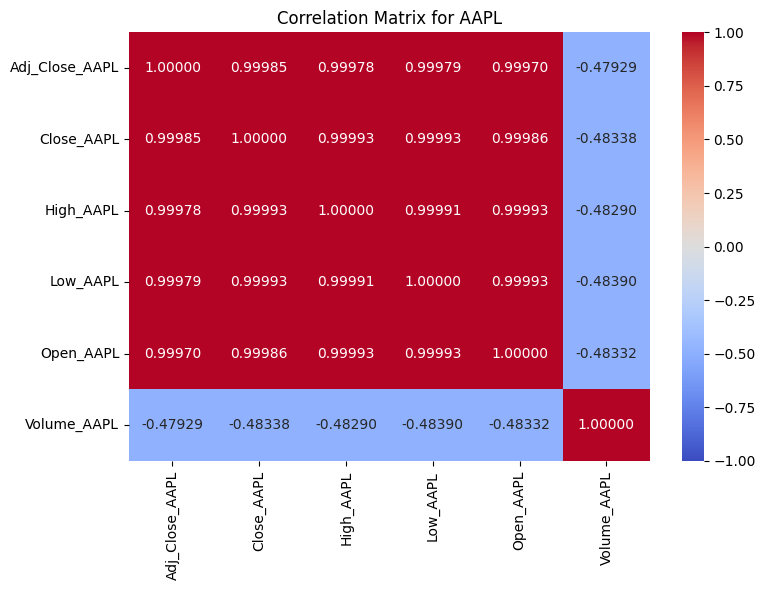

Correlation matrix for MSFT:


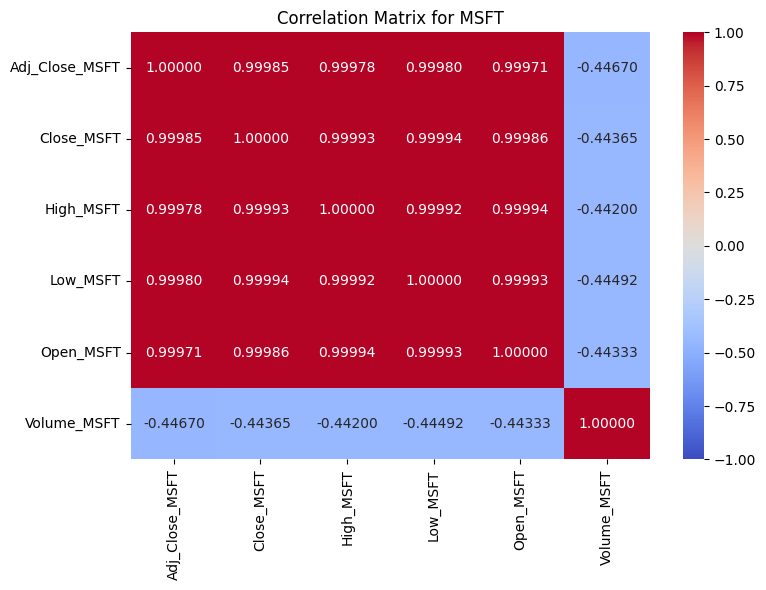

Correlation matrix for AMZN:


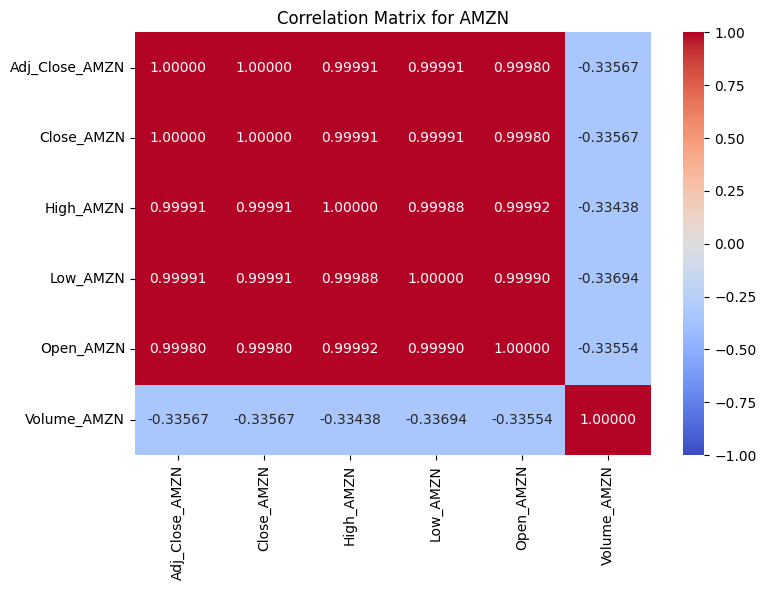

Correlation matrix for META:


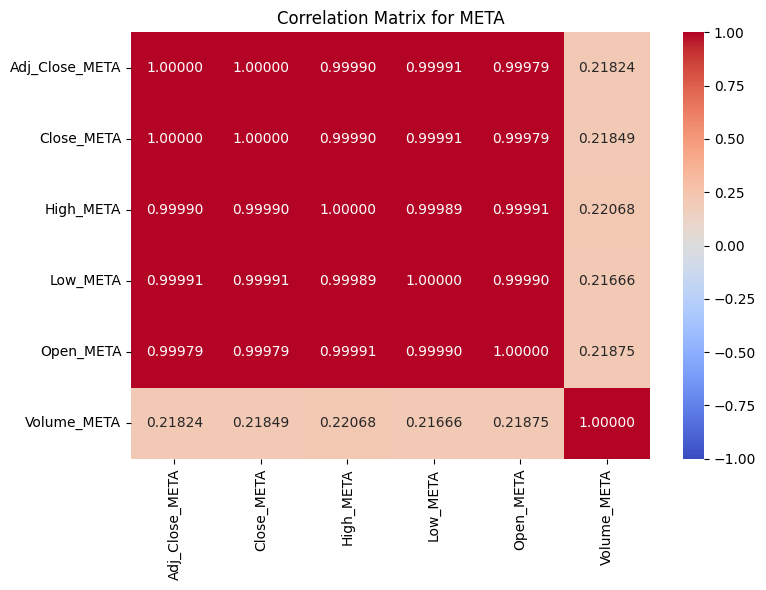

Correlation matrix for ZM:


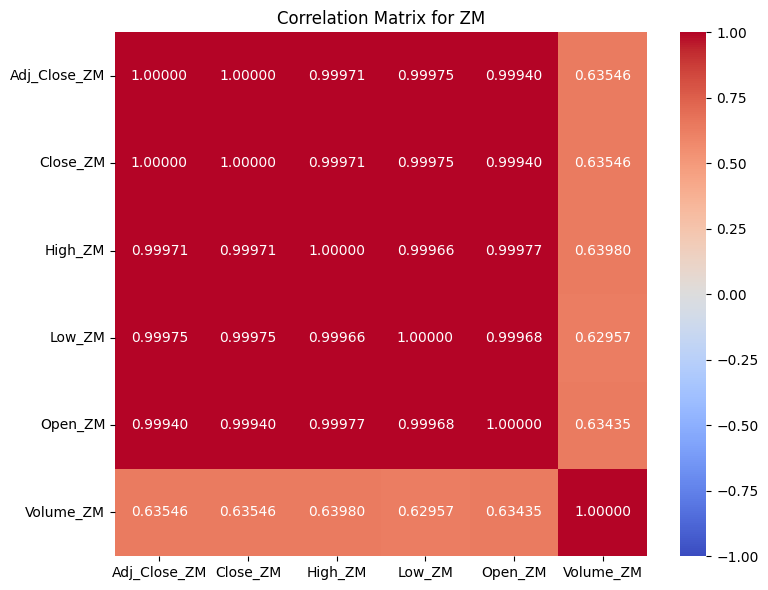

In [20]:
def correlation(spark_df, symbols):
    for symbol in symbols:
        # Select all columns containing the current symbol in their names
        current_columns = [col for col in spark_df.columns if symbol in col]

        # Initialize a dictionary to store the correlations for the current symbol
        current_correlations = {}

        # Calculate the correlation between each pair of columns for the current symbol
        for col1 in current_columns:
            current_correlations[col1] = {}
            for col2 in current_columns:
                if col1 != col2:  # Skip the correlation of a column with itself
                    # Calculate the correlation between col1 and col2
                    correlation = spark_df.stat.corr(col1, col2)
                    current_correlations[col1][col2] = correlation
                else:
                    # Set the correlation of a column with itself to 1
                    current_correlations[col1][col2] = 1.0
        # Convertir le dictionnaire de corrélation en un DataFrame pandas pour un meilleur affichage
        correlation_df = pd.DataFrame(current_correlations)

        # Afficher la matrice de corrélation pour le symbole actuel
        print(f"Correlation matrix for {symbol}:")

        # Tracer la heatmap de la matrice de corrélation
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.5f', vmin=-1, vmax=1)

        # Ajouter un titre
        plt.title(f'Correlation Matrix for {symbol}')
        plt.tight_layout()
        plt.show()
correlation(spark_df, symbols)


#The exploration process

 What is the average of the opening and closing prices for each stock price and for different time periods (week, month, year)?

This code uses an interactive widget to compute and display the average opening and closing prices of stock symbols based on a selected time period (week, month, or year). The RadioButtons widget lets the user choose the period, and the output widget displays the results. The avg_opening_closing function filters data by the start date and calculates the average prices for each symbol, grouping the data by the chosen period. When the user selects a period, the on_radio_change function triggers the calculation and displays the results in the output. Data is shown using Spark and converted to Pandas for easy visualization.

In [21]:
radio = widgets.RadioButtons(
    options=["week", "month", "year"],
    description="Time Period:",
    disabled=False
)

output = widgets.Output()
display(radio, output)

def avg_opening_closing(spark_df, symbols, start_date, period):
    spark_df = spark_df.filter(col("Date") >= lit(start_date))

    if spark_df.count() == 0:
        raise ValueError(f"Aucune donnée disponible après {start_date}.")

    spark_df = spark_df.withColumn("Year", year("Date")) \
                       .withColumn("Month", month("Date")) \
                       .withColumn("Week", weekofyear("Date"))

    plot_data = {}

    for symbol in symbols:
        open_col = f"Open_{symbol}"
        close_col = f"Close_{symbol}"

        if open_col in spark_df.columns and close_col in spark_df.columns:
            if period == "year":
                avg_prices = spark_df.groupBy("Year").agg(
                    avg(open_col).alias(f"Avg_Open_{symbol}_Year"),
                    avg(close_col).alias(f"Avg_Close_{symbol}_Year")
                ).orderBy("Year")
            elif period == "month":
                avg_prices = spark_df.groupBy("Year", "Month").agg(
                    avg(open_col).alias(f"Avg_Open_{symbol}_Month"),
                    avg(close_col).alias(f"Avg_Close_{symbol}_Month")
                ).orderBy("Year", "Month")
            elif period == "week":
                avg_prices = spark_df.groupBy("Year", "Week").agg(
                    avg(open_col).alias(f"Avg_Open_{symbol}_Week"),
                    avg(close_col).alias(f"Avg_Close_{symbol}_Week")
                ).orderBy("Year", "Week")
            else:
                continue

            plot_data[symbol] = avg_prices.toPandas()

            with output:
                avg_prices.show()

    return plot_data

def on_radio_change(change):
    period = radio.value
    with output:
        clear_output(wait=True)  # Erased the older value
        print(f"Calcul for the period : {period}")
        try:
            plot_data = avg_opening_closing(spark_df, symbols, "2018-01-01", period)
        except Exception as e:
            print(f"Erreur : {e}")

radio.observe(on_radio_change, names="value")


RadioButtons(description='Time Period:', options=('week', 'month', 'year'), value='week')

Output()

How do the stock prices change day to day and month to month (maybe you can
create new columns to save those calculation)?

This code creates an interactive widget that calculates and displays the daily changes in closing prices for selected stock symbols starting from a user-specified date. The `SelectionSlider` widget allows the user to choose a start date, and the output widget shows the results. The `calculate_daily_changes` function computes the daily price change by subtracting the previous day's closing price using the `lag` function. When the start date is changed, the `on_date_slider_change` function filters the data and calls `calculate_daily_changes` to display the daily changes in closing prices. The results are shown for each symbol starting from the selected date.

In [22]:
output = widgets.Output()

def calculate_daily_changes(spark_df, symbols):
    for symbol in symbols:
        close_col = f"Close_{symbol}"

        window_spec = Window.orderBy("Date")

        spark_df = spark_df.withColumn(
            f"Daily_Change_{symbol}",
            col(close_col) - lag(close_col).over(window_spec)
        )
    return spark_df

dates = [str(row["Date"]) for row in spark_df.select("Date").distinct().orderBy("Date").collect()]
min_date = dates[0]
max_date = dates[-1]

date_slider = widgets.SelectionSlider(
    options=dates,
    value=min_date,
    description="Start Date:",
    continuous_update=False
)

def on_date_slider_change(change):
    with output:
        clear_output(wait=True)

        start_date = date_slider.value
        print(f"Affichage des changements quotidiens à partir de {start_date} :")

        filtered_df = spark_df.filter(col("Date") >= start_date)

        try:
            daily_change_df = calculate_daily_changes(filtered_df, symbols)
            for symbol in symbols:
                daily_change_df.select(
                    "Date",
                    f"Close_{symbol}",
                    f"Daily_Change_{symbol}"
                ).show()
        except Exception as e:
            print(f"Erreur : {e}")

date_slider.observe(on_date_slider_change, names="value")

display(date_slider, output)


SelectionSlider(continuous_update=False, description='Start Date:', options=('2001-01-02', '2001-01-03', '2001…

Output()

Monthly change function

This code defines a function, `calculate_monthly_changes`, that calculates the monthly changes in the average closing prices of stock symbols. It first extracts the year and month from the `Date` column, then groups the data by these two columns to calculate the average closing prices for each symbol. The function then computes the monthly change by comparing the average closing price of the current month with the previous month using the `lag` function. The resulting DataFrame, which includes the monthly changes for each symbol, is joined back to the original DataFrame. The final output is saved as a CSV file containing the distinct monthly changes for all symbols.

In [23]:
def calculate_monthly_changes(spark_df, symbols):
    spark_df = spark_df.withColumn("Year", year("Date")) \
                       .withColumn("Month", month("Date"))

    for symbol in symbols:
        print(f"Average of the opening and closing prices for {symbol}:")
        close_col = f"Close_{symbol}"

        if close_col in spark_df.columns:
            avg_prices_month = spark_df.groupBy("Year", "Month").agg(
                {close_col: "avg"}
            ).withColumnRenamed(f"avg({close_col})", f"Avg_Close_{symbol}_Month")

            window_spec = Window.orderBy("Year", "Month")

            avg_prices_month = avg_prices_month.withColumn(
                f"Avg_Close_{symbol}_Prev_Month",
                lag(f"Avg_Close_{symbol}_Month").over(window_spec)
            )

            avg_prices_month = avg_prices_month.withColumn(
                f"Monthly_Change_{symbol}",
                col(f"Avg_Close_{symbol}_Month") - col(f"Avg_Close_{symbol}_Prev_Month")
            )
            spark_df = spark_df.join(
                avg_prices_month,
                on=["Year", "Month"],
                how="left"
            )
            avg_prices_month.show()
    filtered_df = spark_df.select(["Year", "Month"] + [col(c) for c in spark_df.columns if c.startswith("Monthly")]).distinct().orderBy(["Year","Month"])
    return filtered_df
Monthly_change = calculate_monthly_changes(spark_df, symbols)
Monthly_change.toPandas().to_csv("monthly_change.csv", index=False)


Average of the opening and closing prices for AAPL:
+----+-----+--------------------+-------------------------+--------------------+
|Year|Month|Avg_Close_AAPL_Month|Avg_Close_AAPL_Prev_Month| Monthly_Change_AAPL|
+----+-----+--------------------+-------------------------+--------------------+
|2001|    1|    0.32918800058819|                     NULL|                NULL|
|2001|    2|   0.350564054752651|         0.32918800058819|0.021376054164461034|
|2001|    3|  0.3705722296779806|        0.350564054752651| 0.02000817492532958|
|2001|    4|  0.4056786999106407|       0.3705722296779806|0.035106470232660114|
|2001|    5|  0.4202029068361629|       0.4056786999106407|0.014524206925522198|
|2001|    6|  0.3844814286345527|       0.4202029068361629| -0.0357214782016102|
|2001|    7| 0.38325681005205425|       0.3844814286345527|-0.00122461858249...|
|2001|    8| 0.33297365515128424|      0.38325681005205425|-0.05028315490077001|
|2001|    9|  0.2964643359184265|      0.3329736551512842

Based on the opening and closing price, calculate the daily return of each stock


This code defines the calculate_daily_return function, which calculates the daily return for each symbol based on the opening and closing prices. The daily return is calculated using the formula (Close - Open) / Open. The function checks if the relevant columns (open and close prices) exist in the DataFrame, and if so, it computes the daily return and adds it as a new column. The results, including the date, opening price, closing price, and daily return for each symbol, are displayed in the DataFrame. Finally, the updated DataFrame is returned.

In [24]:
def calculate_daily_return(spark_df, symbols):
    for symbol in symbols:
        open_col = f"Open_{symbol}"
        close_col = f"Close_{symbol}"

        if open_col in spark_df.columns and close_col in spark_df.columns:
            # Calculate the daily return as (Close - Open) / Open
            spark_df = spark_df.withColumn(
                f"Daily_Return_{symbol}",
                (col(close_col) - col(open_col)) / col(open_col)
            )
        else:
            print(f"Columns for {symbol} not found in the DataFrame.")

    columns_to_show = ["Date"]  # Inclure la colonne "Date"
    for symbol in symbols:
        columns_to_show.extend([f"Open_{symbol}", f"Close_{symbol}", f"Daily_Return_{symbol}"])

    spark_df.select(columns_to_show).show()
    return spark_df

daily_return = calculate_daily_return(spark_df, symbols)

+----------+---------+----------+--------------------+---------+----------+--------------------+---------+----------+--------------------+---------+----------+-----------------+-------+--------+---------------+
|      Date|Open_AAPL|Close_AAPL|   Daily_Return_AAPL|Open_MSFT|Close_MSFT|   Daily_Return_MSFT|Open_AMZN|Close_AMZN|   Daily_Return_AMZN|Open_META|Close_META|Daily_Return_META|Open_ZM|Close_ZM|Daily_Return_ZM|
+----------+---------+----------+--------------------+---------+----------+--------------------+---------+----------+--------------------+---------+----------+-----------------+-------+--------+---------------+
|2001-01-02| 0.265625|  0.265625|                 0.0|  22.0625|   21.6875| -0.0169971671388102| 0.790625|   0.69375|-0.12252958765232215|     NULL|      NULL|             NULL|   NULL|    NULL|           NULL|
|2001-01-03| 0.258929|  0.292411| 0.12930951532512544| 21.59375|  23.96875| 0.10998552821997105|  0.68125|  0.878125|  0.2889908882977858|     NULL|      NU

This code defines the `plot_daily_returns` function, which visualizes the daily returns for each stock symbol over time. It first converts the Spark DataFrame to a Pandas DataFrame and ensures that the `Date` column is in the correct datetime format. The function then plots the daily returns for each symbol, using the `Date` as the x-axis and the daily returns as the y-axis. Missing columns are reported, and a legend, grid, and proper labels are added to the plot for clarity. Finally, the plot is displayed using Matplotlib.

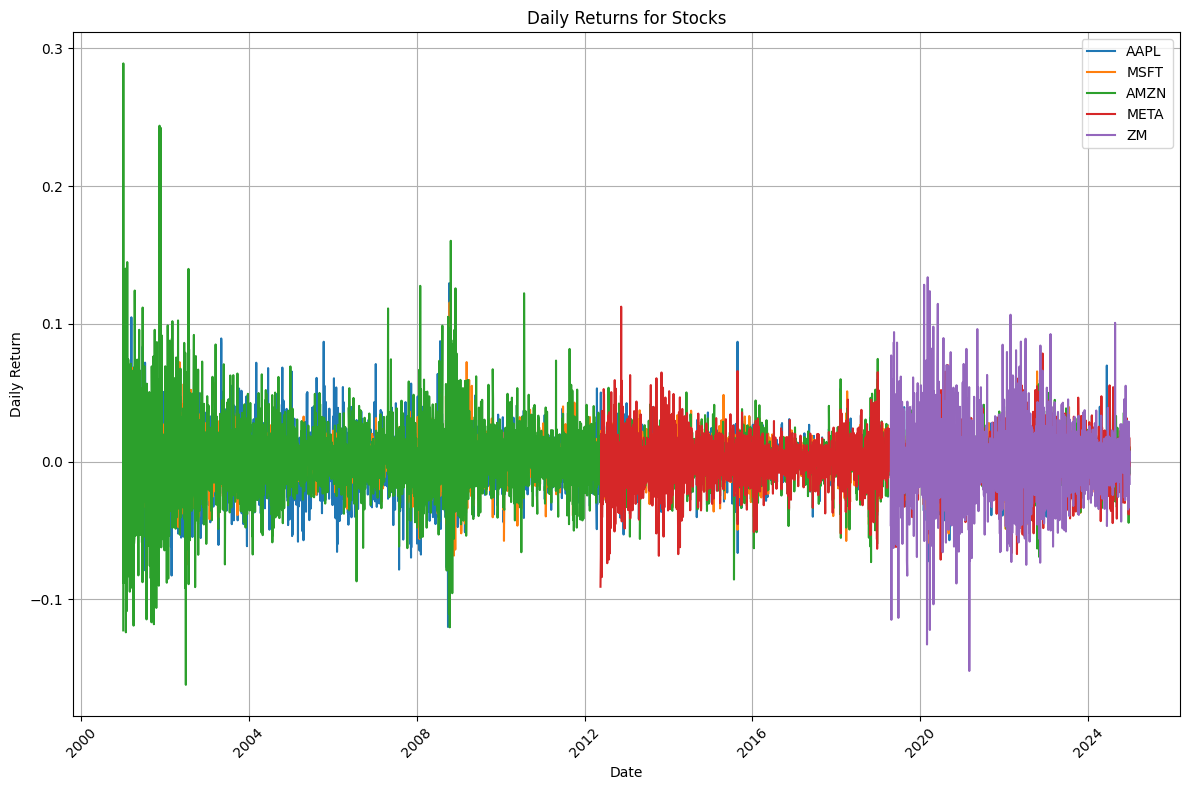

In [25]:
def plot_daily_returns(spark_df, symbols):
    spark_df_pandas = spark_df.toPandas()

    # Ensure 'Date' is in datetime format
    spark_df_pandas['Date'] = pd.to_datetime(spark_df_pandas['Date'])

    plt.figure(figsize=(12, 8))
    for symbol in symbols:
        col_name = f"Daily_Return_{symbol}"
        if col_name in spark_df_pandas.columns:
            plt.plot(spark_df_pandas['Date'], spark_df_pandas[col_name], label=symbol)
        else:
            print(f"Column {col_name} not found!")

    plt.title('Daily Returns for Stocks')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_returns(daily_return, symbols)

What are the stocks with the highest daily return?

This code defines the function `get_max_daily_return_with_stock`, which identifies the stock symbol that has the maximum daily return on each day. The function first creates a new column, `Max_Daily_Return`, that contains the highest daily return for each row (across all symbols). It then creates a `Stock` column that stores the name of the stock with the maximum daily return by comparing each symbol's daily return to `Max_Daily_Return`. Finally, the result is a DataFrame that shows the date, the maximum daily return, and the corresponding stock symbol, sorted by the maximum daily return in descending order.

In [26]:
def get_max_daily_return_with_stock(spark_df, symbols):
    daily_return_cols = [f"Daily_Return_{symbol}" for symbol in symbols]

    spark_df = spark_df.withColumn("Max_Daily_Return", greatest(*[col(c) for c in daily_return_cols]))

    stock_condition = None
    for i, column in enumerate(daily_return_cols):
        if stock_condition is None:
            stock_condition = when(col("Max_Daily_Return") == col(column), column)
        else:
            stock_condition = stock_condition.when(col("Max_Daily_Return") == col(column), column)

    spark_df = spark_df.withColumn("Stock", stock_condition)
    spark_df = spark_df.withColumn("Stock", regexp_replace(col("Stock"), "Daily_Return_", ""))
    result_df = spark_df.select("Date", "Max_Daily_Return", "Stock").orderBy("Max_Daily_Return", ascending=False)

    return result_df

result_df = get_max_daily_return_with_stock(daily_return, symbols)
result_df.show()


+----------+-------------------+-----+
|      Date|   Max_Daily_Return|Stock|
+----------+-------------------+-----+
|2001-01-03| 0.2889908882977858| AMZN|
|2001-11-14|0.24377455664456635| AMZN|
|2001-11-26| 0.2421159515918109| AMZN|
|2008-10-23|0.16024906358723162| AMZN|
|2001-02-06| 0.1447963258079369| AMZN|
|2001-01-24|0.14006511824753556| AMZN|
|2002-07-24|0.13985447022311892| AMZN|
|2020-03-05|0.13378684807256236|   ZM|
|2008-10-10|0.12952175899401483| AAPL|
|2020-02-03|0.12833055615132066|   ZM|
|2008-01-31| 0.1275577148739291| AMZN|
|2008-12-03| 0.1257470468984092| AMZN|
|2001-01-09|0.12446358887712827| AMZN|
|2001-04-12|0.12413798206343159| AMZN|
|2020-03-23|0.12368574181045067|   ZM|
|2010-07-23| 0.1221561051269018| AMZN|
|2008-10-13|0.11548553452150748| MSFT|
|2020-06-01|0.11447757429392903|   ZM|
|2012-11-14|0.11243782019851797| META|
|2001-06-20|0.11180128625451279| AMZN|
+----------+-------------------+-----+
only showing top 20 rows



This code defines the `plot_max_daily_return_per_stock` function, which visualizes the maximum daily return for each stock symbol. It first converts the result DataFrame to a Pandas DataFrame and cleans up the stock names by removing the `Daily_Return_` prefix. The function then filters the symbols of interest, groups the data by stock, and calculates the maximum daily return for each stock. A bar chart is then created to display the maximum daily return for each symbol, with appropriate labels and grid lines for clarity. Finally, the plot is displayed using Matplotlib.

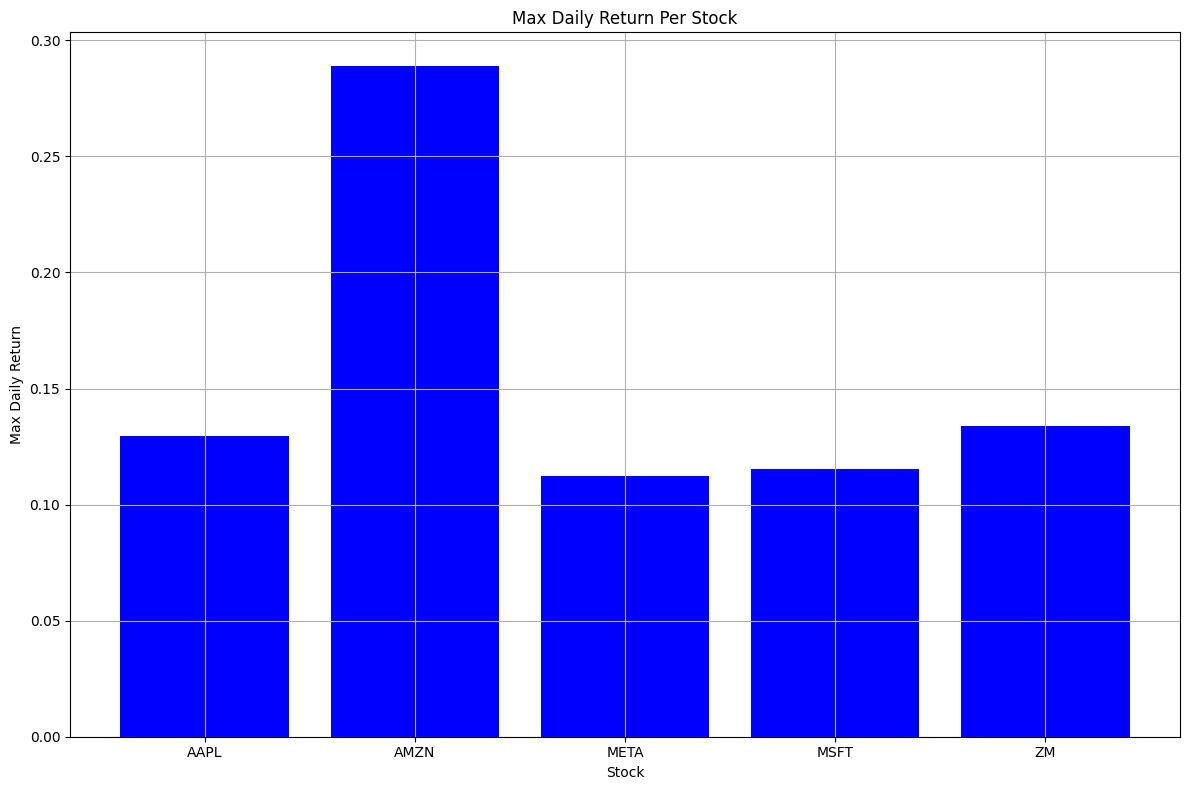

In [27]:
import matplotlib.pyplot as plt

def plot_max_daily_return_per_stock(result_df, symbols):
    result_df_pandas = result_df.toPandas()

    result_df_pandas['Stock'] = result_df_pandas['Stock'].str.replace('Daily_Return_', '')

    max_daily_returns = result_df_pandas[result_df_pandas['Stock'].isin(symbols)] \
                            .groupby('Stock')['Max_Daily_Return'] \
                            .max()

    plt.figure(figsize=(12, 8))
    plt.bar(max_daily_returns.index, max_daily_returns.values, color='blue')
    plt.title('Max Daily Return Per Stock')
    plt.xlabel('Stock')
    plt.ylabel('Max Daily Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_max_daily_return_per_stock(result_df, symbols)


Calculate the average daily return for different periods (week, month, and year)

This code defines the `avg_dailyreturn` function, which calculates the average daily return for each stock symbol over a specified date range (`start_date` to `end_date`) and period (Year, Month, or Week). The function first filters the data to include only the specified date range. Then, depending on the chosen period, it adds columns for Year, Month, or Week. For each stock symbol, it calculates the average daily return, either by grouping the data by the specified period or by calculating an overall average if no period is specified. The function joins the average values to the original DataFrame and displays the results by the selected period. The result is returned as a Spark DataFrame, and the values are shown based on the grouping period.

In [28]:
def avg_dailyreturn(spark_df, symbols, start_date, end_date, period):
    spark_df = spark_df.filter((col("Date") >= start_date) & (col("Date") <= end_date))

    if spark_df.count() == 0:
        raise ValueError(f"No data available for the period {start_date} to {end_date}.")

    if period == "Year":
        spark_df = spark_df.withColumn("Year", year("Date"))
    elif period == "Month":
        spark_df = spark_df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
    elif period == "Week":
        spark_df = spark_df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))

    for symbol in symbols:
        daily_return_col = f"Daily_Return_{symbol}"

        if daily_return_col in spark_df.columns:
            if period == "Year":
                avg_df = spark_df.groupBy("Year").agg(
                    avg(col(daily_return_col)).alias(f"Avg_Daily_Return_{symbol}_Year")
                )
                spark_df = spark_df.join(avg_df, on="Year", how="left")

            elif period == "Month":
                avg_df = spark_df.groupBy("Year", "Month").agg(
                    avg(col(daily_return_col)).alias(f"Avg_Daily_Return_{symbol}_Month")
                )
                spark_df = spark_df.join(avg_df, on=["Year", "Month"], how="left")

            elif period == "Week":
                avg_df = spark_df.groupBy("Year", "Week").agg(
                    avg(col(daily_return_col)).alias(f"Avg_Daily_Return_{symbol}_Week")
                )
                spark_df = spark_df.join(avg_df, on=["Year", "Week"], how="left")

            else:
                avg_value = spark_df.agg(avg(col(daily_return_col)).alias(f"Avg_Daily_Return_{symbol}")).collect()[0][0]

                spark_df = spark_df.withColumn(f"Avg_Daily_Return_{symbol}", lit(avg_value))



    columns_to_display = [col for col in spark_df.columns if "Avg_Daily_Return_" in col]
    if period == "Year":
        spark_df.select("Year", *columns_to_display).distinct().orderBy("Year").show()
    elif period == "Month":
        spark_df.select("Year", "Month", *columns_to_display).distinct().orderBy("Year", "Month").show()
    elif period == "Week":
        spark_df.select("Year", "Week", *columns_to_display).distinct().orderBy("Year", "Week").show()
    else:
        spark_df.select(*columns_to_display).distinct().show()


    return spark_df

start_date = "2020-01-01"
end_date = "2023-01-04"
period = "Month"  # Can be 'Year', 'Month', 'Week', or None
result_df = avg_dailyreturn(daily_return, symbols, start_date, end_date, period)


+----+-----+---------------------------+---------------------------+---------------------------+---------------------------+-------------------------+
|Year|Month|Avg_Daily_Return_AAPL_Month|Avg_Daily_Return_MSFT_Month|Avg_Daily_Return_AMZN_Month|Avg_Daily_Return_META_Month|Avg_Daily_Return_ZM_Month|
+----+-----+---------------------------+---------------------------+---------------------------+---------------------------+-------------------------+
|2020|    1|       0.002568335509226...|       2.807740870123983E-4|       -8.18773842893139...|       0.001932631358850...|     0.003412566658408...|
|2020|    2|       0.003538745808418503|       0.001428989849490...|       3.750821848495402E-4|       0.002525892280688...|     0.006229269789340...|
|2020|    3|       0.005227278220131...|       0.003973256387518505|       0.005386482704596...|       0.003485093996838419|     0.013002876771325701|
|2020|    4|       0.002238315734706...|       -7.29445257243333...|       0.006271593900401..

# Moving average

This code defines the `calculate_moving_average` function, which computes the moving average for a specified column over a given number of periods. It creates a window specification based on the "Date" column, including the current row and the previous `(num_periods - 1)` rows. The function then adds a new column containing the moving average and displays the result, showing the date, the original column values, and the calculated moving average. The function is called with a chosen column (in this case, `Open_MSFT`) and the number of periods (50), and it returns the updated DataFrame with the moving average column.

In [29]:
def calculate_moving_average(spark_df, column_name, num_periods):
    #define a window that includes the current row and the previous (num_periods - 1) rows
    window_spec = Window.orderBy("Date").rowsBetween(-(num_periods - 1), 0)

    # Add the moving average column
    moving_avg_col = f"{column_name}_Moving_Avg_{num_periods}"
    spark_df = spark_df.withColumn(
        moving_avg_col,
        avg(col(column_name)).over(window_spec)
    )
    # Display the DataFrame with the moving average column
    spark_df.select("Date", column_name, f"{column_name}_Moving_Avg_{num_periods}").show()

    return spark_df

choosed_col = "Open_MSFT"
number_of_periods = 50
mv_avg = calculate_moving_average(spark_df, choosed_col, number_of_periods)


+----------+---------+-----------------------+
|      Date|Open_MSFT|Open_MSFT_Moving_Avg_50|
+----------+---------+-----------------------+
|2001-01-02|  22.0625|                22.0625|
|2001-01-03| 21.59375|              21.828125|
|2001-01-04| 23.90625|     22.520833333333332|
|2001-01-05|    24.25|              22.953125|
|2001-01-08| 24.46875|               23.25625|
|2001-01-09|     25.0|              23.546875|
|2001-01-10|     25.5|     23.825892857142858|
|2001-01-11|     26.5|            24.16015625|
|2001-01-12|  27.4375|     24.524305555555557|
|2001-01-16|  26.6875|              24.740625|
|2001-01-17|  26.8125|     24.928977272727273|
|2001-01-18| 26.84375|     25.088541666666668|
|2001-01-19|     30.0|     25.466346153846153|
|2001-01-22|   30.375|     25.816964285714285|
|2001-01-23|   29.875|                26.0875|
|2001-01-24|     30.5|            26.36328125|
|2001-01-25|   31.375|     26.658088235294116|
|2001-01-26|     30.5|      26.87152777777778|
|2001-01-29| 

This code defines the `plot_moving_average` function, which plots the original data and its moving average for a given column and period. It first constructs the name of the moving average column, then converts the Spark DataFrame into a Pandas DataFrame for easier plotting. The function ensures that the `Date` column is in a proper datetime format. Using Seaborn, it plots both the original column and its moving average over time. The plot includes labels, titles, and a legend to differentiate between the original data and the moving average. The `plt.tight_layout()` ensures that the plot elements fit nicely within the figure. Finally, the function is called with the `mv_avg` DataFrame, the selected column (`Open_MSFT`), and the chosen period (`50`).

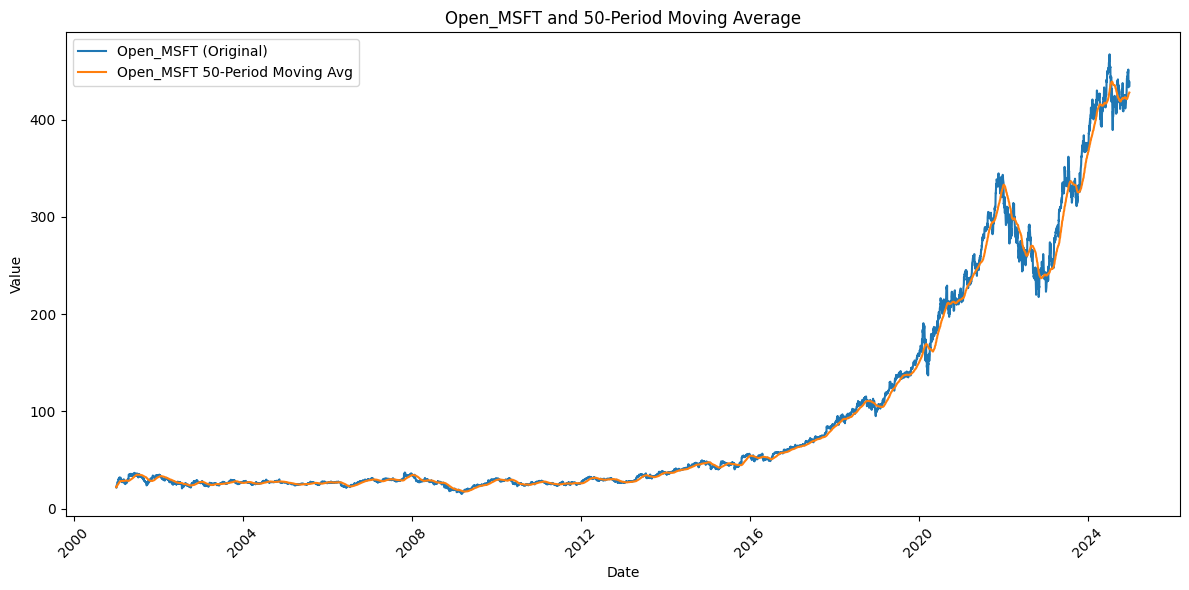

In [30]:
def plot_moving_average(spark_df, column_name, num_periods):
    # Define the name of the moving average column
    moving_avg_col = f"{column_name}_Moving_Avg_{num_periods}"

    # Convert the Spark DataFrame to a Pandas DataFrame for plotting
    pandas_df = spark_df.select("Date", column_name, moving_avg_col).toPandas()

    # Ensure the 'Date' column is in datetime format
    pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])

    # Plot the original data and moving average
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=pandas_df, x="Date", y=column_name, label=f"{column_name} (Original)")
    sns.lineplot(data=pandas_df, x="Date", y=moving_avg_col, label=f"{column_name} {num_periods}-Period Moving Avg")

    # Add titles and labels
    plt.title(f"{column_name} and {num_periods}-Period Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_moving_average(mv_avg, choosed_col, number_of_periods)

This code is for the insight

This code calculates the moving averages for the closing prices of stocks over multiple periods and saves the results as CSV files. The process starts by filtering the DataFrame `spark_df` to include only rows after "2018-01-01". The `calculate_moving_average` function is applied to the `Close_AAPL` column for 50 periods, then for 200 periods, and the resulting DataFrame is saved as "mv_avg.csv". Next, for each symbol in `symbols`, the function calculates a 20-period moving average for its corresponding `Close` column and applies it iteratively. The final DataFrame with the 20-period moving averages is saved as "mv_avg_20.csv".

In [31]:
#moving average for the insight
spark_df_mv = spark_df.filter(col("Date") > "2018-01-01")
choosed_col = "Close_AAPL"
number_of_periods= 50
mv_avg = calculate_moving_average(spark_df_mv, choosed_col, number_of_periods)
number_of_periods= 200
mv_avg = calculate_moving_average(mv_avg, choosed_col, number_of_periods)
mv_avg.toPandas().to_csv("mv_avg.csv")
number_of_periods= 20
for i, symbol in enumerate(symbols):
    choosed_col = f"Close_{symbol}"
    if i == 0:
        mv_avg_20 = calculate_moving_average(spark_df, choosed_col, number_of_periods)
    else:
        mv_avg_20 = calculate_moving_average(mv_avg_20, choosed_col, number_of_periods)

mv_avg_20.toPandas().to_csv("mv_avg_20.csv")


+----------+----------+------------------------+
|      Date|Close_AAPL|Close_AAPL_Moving_Avg_50|
+----------+----------+------------------------+
|2018-01-02|    43.065|      43.064998626708984|
|2018-01-03|   43.0575|      43.061248779296875|
|2018-01-04|   43.2575|       43.12666575113932|
|2018-01-05|     43.75|       43.28249931335449|
|2018-01-08|   43.5875|      43.343499755859376|
|2018-01-09|   43.5825|       43.38333320617676|
|2018-01-10|   43.5725|       43.41035679408482|
|2018-01-11|     43.82|      43.461562156677246|
|2018-01-12|   44.2725|      43.551666259765625|
|2018-01-16|   44.0475|       43.60124969482422|
|2018-01-17|    44.775|       43.70795440673828|
|2018-01-18|    44.815|       43.80020809173584|
|2018-01-19|    44.615|      43.862884521484375|
|2018-01-22|     44.25|       43.89053562709263|
|2018-01-23|     44.26|       43.91516647338867|
|2018-01-24|    43.555|      43.892656087875366|
|2018-01-25|   42.7775|       43.82705867991728|
|2018-01-26|   42.87

Moving average for the insight

In [32]:
choosed_col = "Close_AAPL"
number_of_periods_1 = 50
mv_avg = calculate_moving_average(mv_avg, choosed_col, number_of_periods_1)
number_of_periods_2 = 200
mv_avg = calculate_moving_average(mv_avg, choosed_col, number_of_periods_2)

+----------+----------+------------------------+
|      Date|Close_AAPL|Close_AAPL_Moving_Avg_50|
+----------+----------+------------------------+
|2018-01-02|    43.065|      43.064998626708984|
|2018-01-03|   43.0575|      43.061248779296875|
|2018-01-04|   43.2575|       43.12666575113932|
|2018-01-05|     43.75|       43.28249931335449|
|2018-01-08|   43.5875|      43.343499755859376|
|2018-01-09|   43.5825|       43.38333320617676|
|2018-01-10|   43.5725|       43.41035679408482|
|2018-01-11|     43.82|      43.461562156677246|
|2018-01-12|   44.2725|      43.551666259765625|
|2018-01-16|   44.0475|       43.60124969482422|
|2018-01-17|    44.775|       43.70795440673828|
|2018-01-18|    44.815|       43.80020809173584|
|2018-01-19|    44.615|      43.862884521484375|
|2018-01-22|     44.25|       43.89053562709263|
|2018-01-23|     44.26|       43.91516647338867|
|2018-01-24|    43.555|      43.892656087875366|
|2018-01-25|   42.7775|       43.82705867991728|
|2018-01-26|   42.87

# Correlation

The code defines a function `calculate_correlation` that calculates the correlation between the daily returns of two specified stocks. It takes the `spark_df` DataFrame and two stock column names (e.g., `Open_AAPL` and `Open_MSFT`) as input, checks if both columns exist in the DataFrame, and then calculates their correlation using the `corr` function. The correlation value is then printed and returned.

In this example, the correlation between the opening prices of AAPL (`Open_AAPL`) and MSFT (`Open_MSFT`) is calculated. If either of the specified columns does not exist in the DataFrame, a `ValueError` is raised.

If you run this code, it will output the correlation between the opening prices of AAPL and MSFT.

In [33]:
def calculate_correlation(spark_df, stock1, stock2):

    if stock1 in spark_df.columns and stock2 in spark_df.columns:
        # Calculate correlation
        correlation = spark_df.select(corr(stock1, stock2)).collect()[0][0]
        print(f"The correlation between {stock1} and {stock2} daily returns is: {correlation}")
        return correlation
    else:
        raise ValueError(f"One or both columns ({stock1}, {stock2}) are not found in the DataFrame.")
        # Calculer la corrélation entre les prix de clôture
# Calculate the correlation between the daily returns of AAPL and MSFT
stock1 = "Open_AAPL"
stock2 = "Open_MSFT"
correlation = calculate_correlation(spark_df, stock1, stock2)



The correlation between Open_AAPL and Open_MSFT daily returns is: 0.9869097561027217


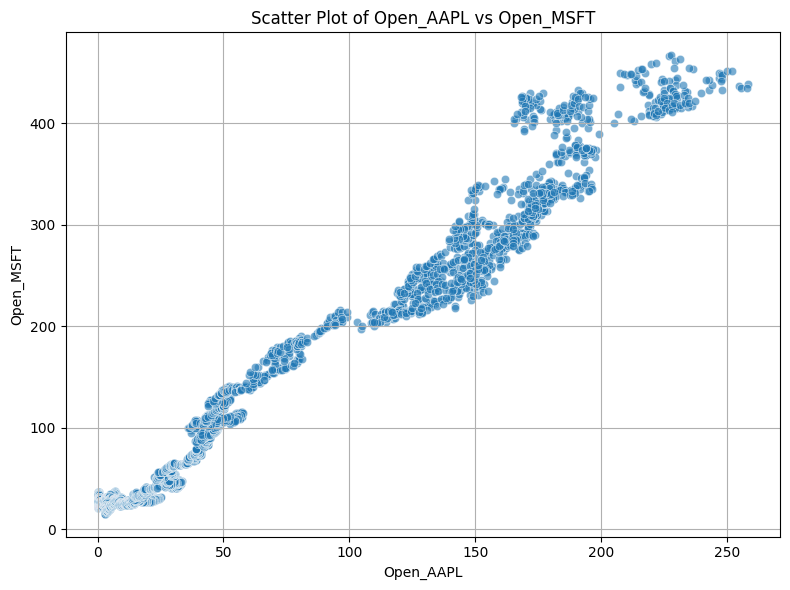

In [34]:
def plot_correlation_scatter(spark_df, stock1, stock2):
    # Convert Spark DataFrame to Pandas for plotting
    pandas_df = spark_df.select(stock1, stock2).toPandas()

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pandas_df, x=stock1, y=stock2, alpha=0.6)
    plt.title(f"Scatter Plot of {stock1} vs {stock2}")
    plt.xlabel(stock1)
    plt.ylabel(stock2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_correlation_scatter(spark_df, stock1, stock2)


# The return rate

The `calculate_return_rate` function computes the return rates for each stock in `symbols` over different time periods: weekly, monthly, and yearly. It first adds columns for the year, month, and week based on the `Date` column, which are then used to group the data.
For each period, it calculates the return rate using the formula:

Return rate = (Ending price - Starting price) / Starting price

The function computes return rates for each symbol for weekly, monthly, and yearly periods. After calculating the return rates, it visualizes them and merges the results back into the original DataFrame.

+----+-------------------+-----------------+---------------------+
|Year|Starting_Price_year|Ending_Price_year|return_rate_AAPL_year|
+----+-------------------+-----------------+---------------------+
|2001|           0.265625|         0.391071|   0.4722672630758846|
|2002|            0.39375|         0.255893|   -0.350113055816134|
|2003|           0.256429|         0.381607|   0.4881585769209894|
|2004|           0.384821|             1.15|   1.9884023558658503|
|2005|           1.156786|           2.5675|    1.219511813074928|
|2006|              2.585|             3.03|  0.17214697356901817|
|2007|           3.081786|         7.074286|   1.2955150597476532|
|2008|           7.116786|         3.048214|  -0.5716867196221744|
|2009|           3.067143|         7.526071|   1.4537725047086836|
|2010|             7.6225|            11.52|   0.5113152567060445|
|2011|              11.63|        14.464286|   0.2437047040579703|
|2012|          14.621429|        19.006071|   0.2998777694290

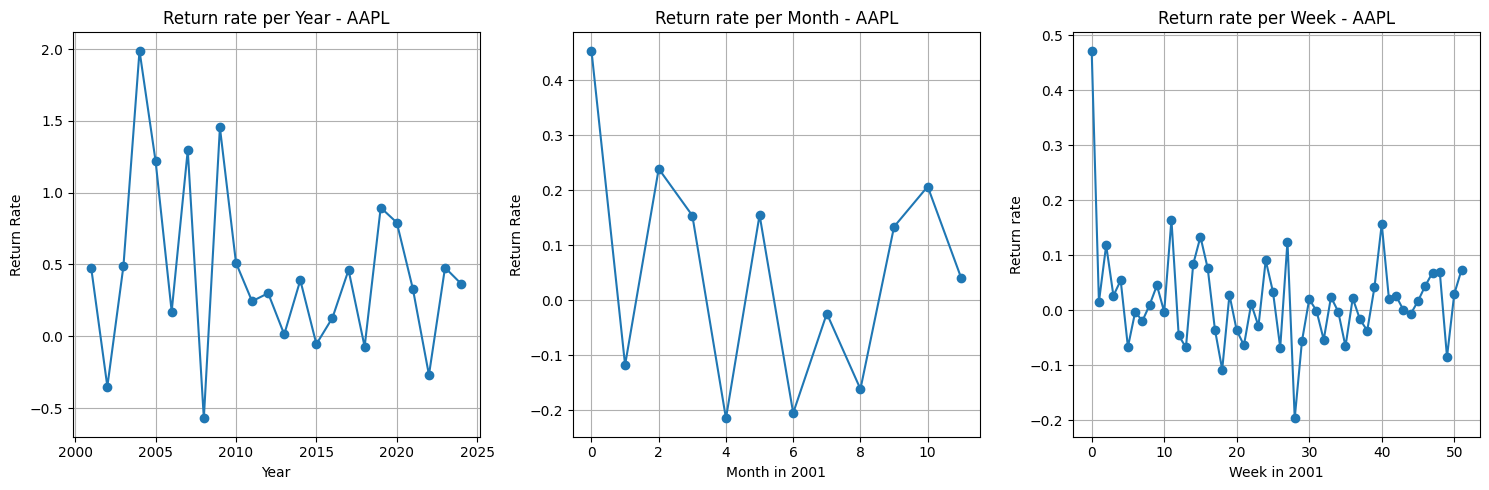

+----+-------------------+-----------------+---------------------+
|Year|Starting_Price_year|Ending_Price_year|return_rate_MSFT_year|
+----+-------------------+-----------------+---------------------+
|2001|            22.0625|           33.125|   0.5014164305949008|
|2002|             33.325|            25.85|  -0.2243060828308407|
|2003|              26.15|            27.37|  0.04665396705545702|
|2004|              27.58|            26.72| -0.03118203817007118|
|2005|               26.8|            26.15| -0.02425371779979073|
|2006|              26.25|            29.86|  0.13752383277529762|
|2007|              29.91|             35.6|  0.19023733385947503|
|2008|              35.79|            19.44|  -0.4568315161561325|
|2009|              19.53|            30.48|   0.5606758049465078|
|2010|              30.62|            27.91| -0.08850427555668011|
|2011|              28.05|            25.96| -0.07450981138803442|
|2012|              26.55|            26.71| 0.006026359774382

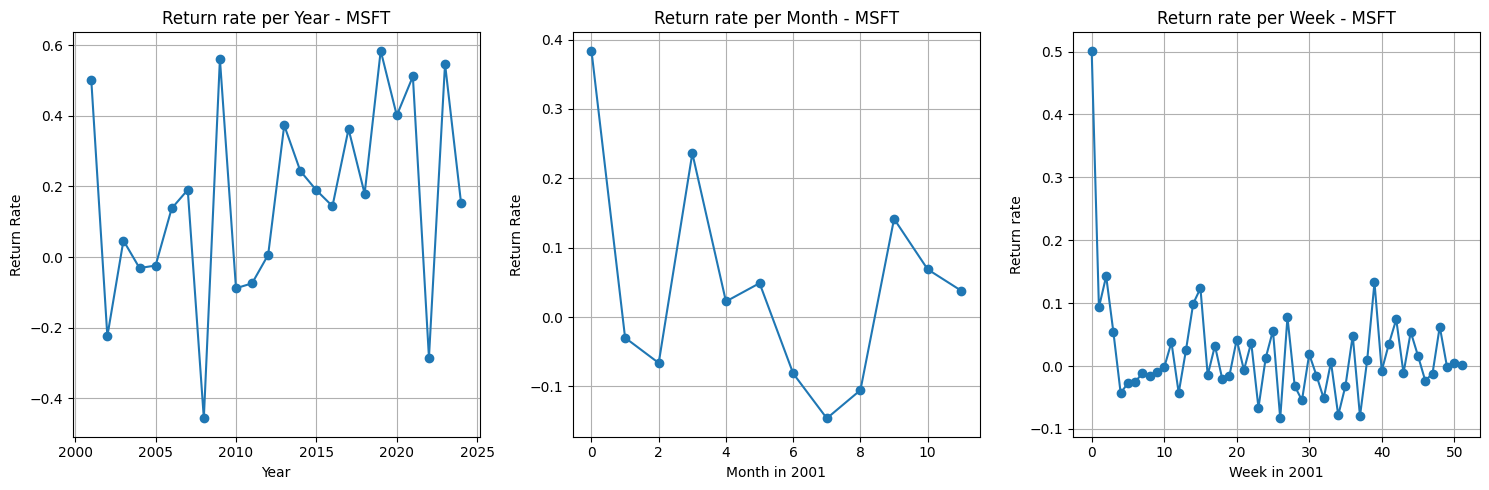

+----+-------------------+-----------------+---------------------+
|Year|Starting_Price_year|Ending_Price_year|return_rate_AMZN_year|
+----+-------------------+-----------------+---------------------+
|2001|           0.790625|            0.541|  -0.3157311938057758|
|2002|             0.5465|           0.9445|   0.7282707815428255|
|2003|             0.9595|            2.631|   1.7420530920522441|
|2004|              2.638|           2.2145|  -0.1605383090212059|
|2005|             2.2475|           2.3575|  0.04894333095215313|
|2006|             2.3735|            1.973| -0.16873816759333657|
|2007|              1.934|            4.632|   1.3950361597399537|
|2008|             4.7675|            2.564| -0.46219193868639186|
|2009|             2.5675|            6.726|   1.6196687565164647|
|2010|             6.8125|              9.0|   0.3211009174311927|
|2011|             9.0685|            8.655| -0.04559738126288843|
|2012|             8.7945|          12.5435|     0.42628909500

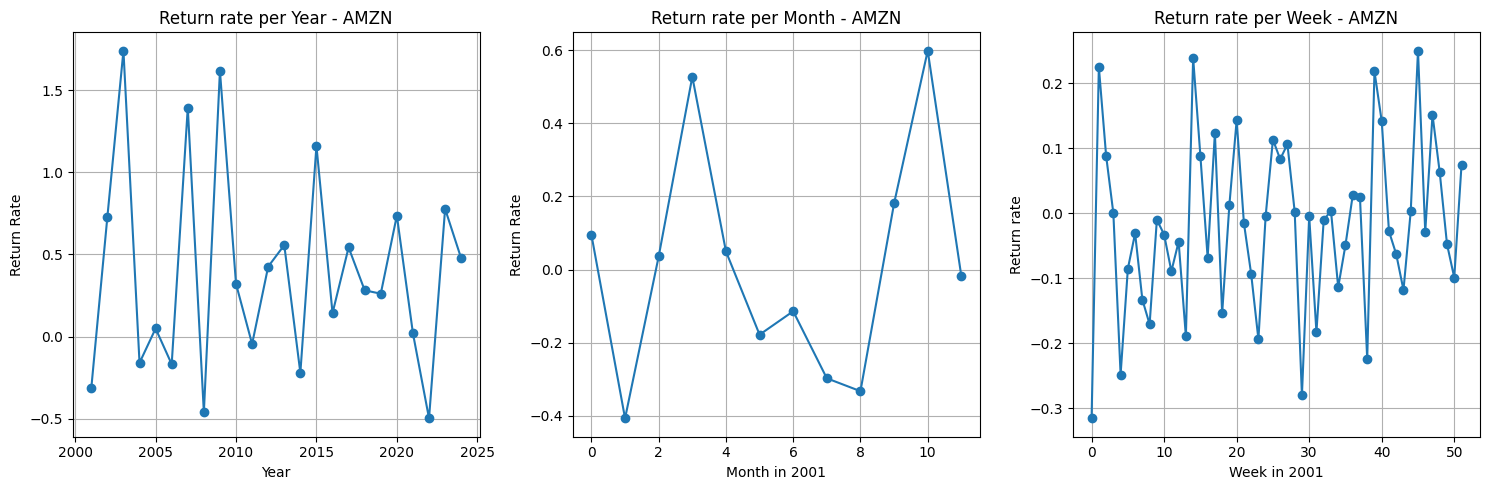

+----+-------------------+-----------------+---------------------+
|Year|Starting_Price_year|Ending_Price_year|return_rate_META_year|
+----+-------------------+-----------------+---------------------+
|2001|               NULL|             NULL|                 NULL|
|2002|               NULL|             NULL|                 NULL|
|2003|               NULL|             NULL|                 NULL|
|2004|               NULL|             NULL|                 NULL|
|2005|               NULL|             NULL|                 NULL|
|2006|               NULL|             NULL|                 NULL|
|2007|               NULL|             NULL|                 NULL|
|2008|               NULL|             NULL|                 NULL|
|2009|               NULL|             NULL|                 NULL|
|2010|               NULL|             NULL|                 NULL|
|2011|               NULL|             NULL|                 NULL|
|2012|               NULL|            26.62|                 N

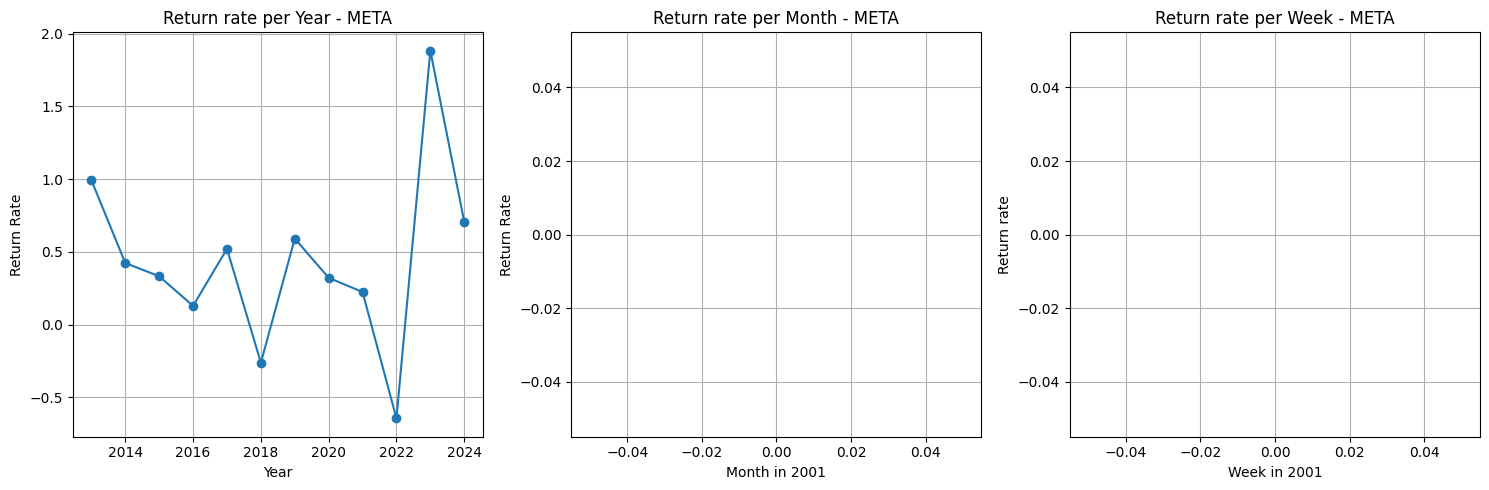

+----+-------------------+-----------------+--------------------+
|Year|Starting_Price_year|Ending_Price_year| return_rate_ZM_year|
+----+-------------------+-----------------+--------------------+
|2001|               NULL|             NULL|                NULL|
|2002|               NULL|             NULL|                NULL|
|2003|               NULL|             NULL|                NULL|
|2004|               NULL|             NULL|                NULL|
|2005|               NULL|             NULL|                NULL|
|2006|               NULL|             NULL|                NULL|
|2007|               NULL|             NULL|                NULL|
|2008|               NULL|             NULL|                NULL|
|2009|               NULL|             NULL|                NULL|
|2010|               NULL|             NULL|                NULL|
|2011|               NULL|             NULL|                NULL|
|2012|               NULL|             NULL|                NULL|
|2013|    

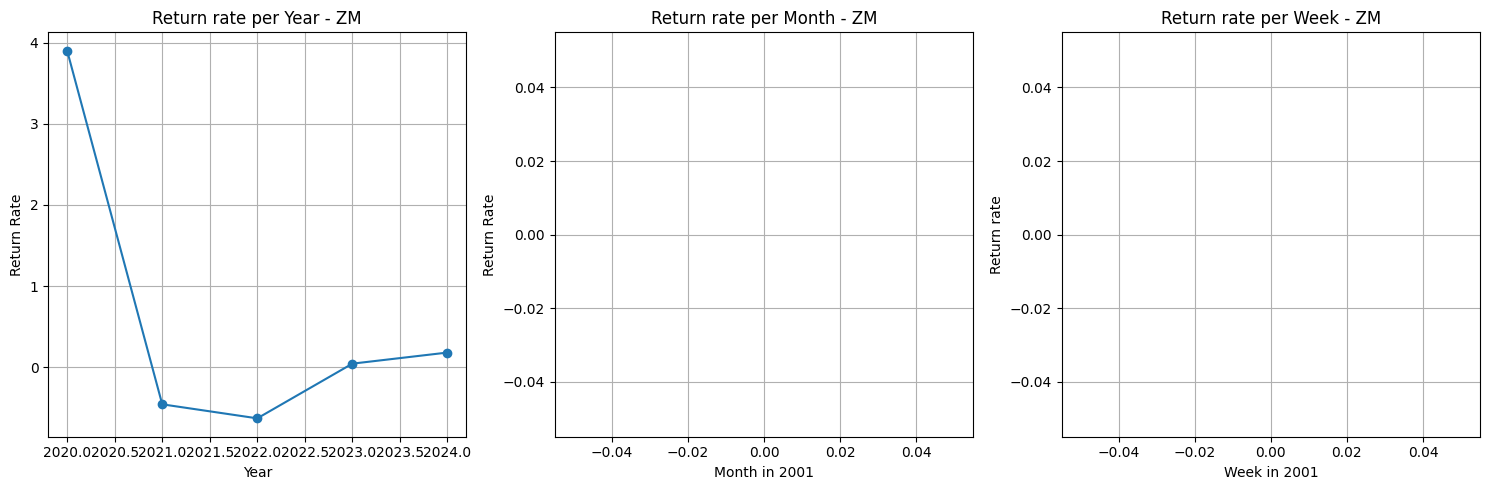

In [35]:
def calculate_return_rate(spark_df, symbols):

    # Add temporal columns for Year, Month, and Week based on the "Date" column
    spark_df = spark_df.withColumn("Year", year("Date")) \
                       .withColumn("Month", month("Date")) \
                       .withColumn("Week", weekofyear("Date"))

    for symbol in symbols:
        open_col = f"Open_{symbol}"
        close_col = f"Close_{symbol}"

        # Calculate the weekly return rate
        return_rate_week = spark_df.groupBy("Year", "Week").agg(
            # first "Open" price of the week
            first(open_col).alias("Starting_Price_week"),
            #last "Close" price of the week
            last(close_col).alias("Ending_Price_week")
        ).withColumn(
            f"return_rate_{symbol}_week",
            #Caluclate the return rate by doing (Last Close Price - First Open price)/ First Open Price
            (col("Ending_Price_week") - col("Starting_Price_week")) / col("Starting_Price_week")
        ).orderBy("Year", "Week")

        # Calculate the monthly return rate
        return_rate_month = spark_df.groupBy("Year", "Month").agg(
            first(open_col).alias("Starting_Price_month"),
            last(close_col).alias("Ending_Price_month")
        ).withColumn(
            f"return_rate_{symbol}_month",
            (col("Ending_Price_month") - col("Starting_Price_month")) / col("Starting_Price_month")
        ).orderBy("Year", "Month")

        # Calculate the yearly return rate
        return_rate_year = spark_df.groupBy("Year").agg(
            first(open_col).alias("Starting_Price_year"),
            last(close_col).alias("Ending_Price_year")
        ).withColumn(
            f"return_rate_{symbol}_year",
            (col("Ending_Price_year") - col("Starting_Price_year")) / col("Starting_Price_year")
        ).orderBy("Year")
        return_rate_year_pd = return_rate_year.toPandas()
        return_rate_month_pd = return_rate_month.toPandas()
        return_rate_week_pd = return_rate_week.toPandas()

        return_rate_month_pd = return_rate_month_pd.head(12)
        return_rate_week_pd = return_rate_week_pd.head(52)
        first_year = return_rate_year_pd["Year"].min()

        return_rate_year.show(30)

            # Visualisation des courbes
        plt.figure(figsize=(15, 5))
       # Courbe annuelle
        plt.subplot(1, 3, 1)
        plt.plot(return_rate_year_pd["Year"], return_rate_year_pd[f"return_rate_{symbol}_year"], marker='o')
        plt.title(f"Return rate per Year - {symbol}")
        plt.xlabel("Year")
        plt.ylabel("Return Rate")
        plt.grid()

         # Courbe mensuelle
        return_rate_month.show()
        plt.subplot(1, 3, 2)
        plt.plot(return_rate_month_pd.index, return_rate_month_pd[f"return_rate_{symbol}_month"], marker='o')
        plt.title(f"Return rate per Month - {symbol}")
        plt.xlabel(f"Month in {first_year}")
        plt.ylabel("Return Rate")
        plt.grid()

        # Courbe hebdomadaire
        return_rate_week.show()
        plt.subplot(1, 3, 3)
        plt.plot(return_rate_week_pd.index, return_rate_week_pd[f"return_rate_{symbol}_week"], marker='o')
        plt.title(f"Return rate per Week - {symbol}")
        plt.xlabel(f"Week in {first_year}")
        plt.ylabel("Return rate")
        plt.grid()

        plt.tight_layout()
        plt.show()

        spark_df = spark_df.join(return_rate_week, on=["Year", "Week"], how="left")

        spark_df = spark_df.join(return_rate_month, on=["Year", "Month"], how="left")

        spark_df = spark_df.join(return_rate_year, on=["Year"], how="left")

    return spark_df
return_rate = calculate_return_rate(spark_df, symbols)


The `calculate_max_return_rate` function filters the `spark_df` to include data after the specified `start_date` and in the specified `year` and `month`. If no data is found, it raises a `ValueError`. After filtering, the Spark DataFrame is converted into a Pandas DataFrame for further analysis. The function then calculates the maximum return rate for each stock symbol in the specified period by using the `max()` function on the relevant return rate column. The results are printed and visualized with a bar chart showing the maximum return rates for each stock. Finally, the function returns a dictionary containing the stock symbols and their corresponding maximum return rates.


Max Return Rate for the period
{'AAPL': 0.05326669243161818, 'MSFT': 0.061732817233727595, 'AMZN': 0.14537328520865303, 'META': nan, 'ZM': nan}


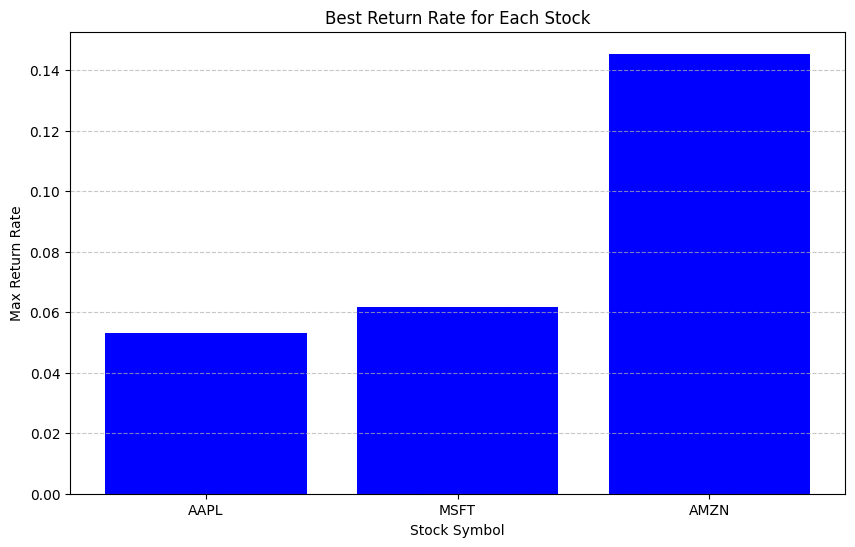

{'AAPL': 0.05326669243161818,
 'MSFT': 0.061732817233727595,
 'AMZN': 0.14537328520865303,
 'META': nan,
 'ZM': nan}

In [36]:
def calculate_max_return_rate(spark_df, symbols, start_date, specify_year, specify_month):
    # Filter the DataFrame for dates greater than or equal to start_date and in the period
    spark_df = spark_df.filter((col("Date") >= lit(start_date)) &
                               (year("Date") == specify_year) &
                               (month("Date") == specify_month))

    # Check if there is data available after filtering
    if spark_df.count() == 0:
        raise ValueError(f"Aucune donnée disponible pour {specify_year}-{specify_month}.")

    # Convert Spark DataFrame to Pandas for plotting
    max_return_pd = spark_df.toPandas()

    # Find the maximum return rate for each stock symbol
    max_return_dict = {}
    for symbol in symbols:
        max_return_dict[symbol] = max_return_pd[f"return_rate_{symbol}_month"].max()

    # Display the results
    print("Max Return Rate for the period")
    print(max_return_dict)

    # Plotting the bar chart for best return rate for each stock
    plt.figure(figsize=(10, 6))
    plt.bar(max_return_dict.keys(), max_return_dict.values(), color='blue')
    plt.title("Best Return Rate for Each Stock")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Max Return Rate")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return max_return_dict


calculate_max_return_rate(return_rate, symbols,"2004-08-10", 2009, 11)

Function for the insight

In [37]:
def calculate_return_rate(spark_df, symbols):

    # Add temporal columns for Year, Month, and Week based on the "Date" column
    spark_df = spark_df.withColumn("Year", year("Date"))

    for symbol in symbols:
        open_col = f"Open_{symbol}"
        close_col = f"Close_{symbol}"

        # Calculate the yearly return rate
        return_rate_year = spark_df.groupBy("Year").agg(
            first(open_col).alias("Starting_Price_year"),
            last(close_col).alias("Ending_Price_year")
        ).withColumn(
            f"return_rate_{symbol}_year",
            (col("Ending_Price_year") - col("Starting_Price_year")) / col("Starting_Price_year")
        ).orderBy("Year")
    # Retourner le DataFrame avec les nouvelles colonnes de taux de retour
    return return_rate_year
return_rate = calculate_return_rate(spark_df, ["AAPL"])
return_rate.toPandas().to_csv("return_rate.csv")

# Smart Insights for Strategic Investments

## Trend Analysis Through Candlestick Visualization

This interactive chart allows you to select a company and analyze its stock trend through candlestick patterns. It helps identify market tendencies for better investment decisions.


In [38]:
# Widget to select the company
selection_widget = widgets.RadioButtons(
    options=symbols,
    description="Select a Company:",
    style={'description_width': 'initial'}
)

# Function to load and process data, create plots, and display recommendations
def analyze_stock(new_select):
    # Load the CSV file of the selected company
    df = pd.read_csv(f"{new_select}.csv")

    # Convert the date column to datetime format and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Define the start and end dates for filtering
    start_date = '2024-09-01'
    end_date = '2025-01-01'

    # Filter the data for the defined date range
    df = df.loc[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]

    # Ensure numeric columns to avoid potential errors
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Create a candlestick chart with mplfinance
    fig, axes = mpf.plot(df.tail(100), type='candle', style='yahoo', volume=True, returnfig=True)

    # Display insights based on the selected company
    print("\nStock Trend Analysis Since September 1st, 2024")
    # Display the plot
    plt.show()

    if new_select == "AAPL":
        print("The trend of Apple is currently positive, which may indicate a buying opportunity. The investor should consider buying Apple.")
    elif new_select == "MSFT":
        print("The trend of Microsoft is stable, indicating low volatility. The investor should hold Microsoft for now.")
    elif new_select == "AMZN":
        print("The trend of Amazon is currently positive, which may indicate a buying opportunity. The investor should consider buying Amazon.")
    elif new_select == "META":
        print("The trend of Meta is stable, indicating low volatility. The investor should hold Meta for now.")
    elif new_select == "ZM":
        print("The trend of Zoom is currently positive, which may indicate a buying opportunity. The investor should consider buying Zoom.")

# Link the widget to the analysis function
interactive_plot = widgets.interactive(
    analyze_stock,
    new_select=selection_widget
)

# Display the widget and interactivity
display(interactive_plot)

interactive(children=(RadioButtons(description='Select a Company:', options=('AAPL', 'MSFT', 'AMZN', 'META', '…

## Apple : A Resilient Growth Stock with Cyclical Recoveries

In this insight, we will analyze the evolution of Apple's return rates over the years, identifying key patterns and trends that reflect the stock's performance, resilience, and growth potential.

In [39]:
def apple():
    # Chargement du fichier CSV
    df_return_rate = pd.read_csv("return_rate.csv")

    # Création de la figure avec Plotly
    fig = go.Figure()

    # Ajouter la courbe de taux de rendement
    fig.add_trace(go.Scatter(
        x=df_return_rate['Year'],
        y=df_return_rate['return_rate_AAPL_year'],
        mode='lines',
        line=dict(color='blue', width=2)
    ))

    # Mise en page
    fig.update_layout(
        title="Evolution of Apple's Return Rate Over the Years",
        xaxis_title="Years",
        yaxis_title="Return rate",
        template='plotly_white',
        legend=dict(
            title="Legend",
            orientation="h",
            x=0.5,
            xanchor="center",
            y=-0.2
        )
    )

    # Affichage du graphique
    fig.show()

# Appel de la fonction pour afficher le graphique
apple()


Apple's stock price has significantly increased over the years. In fact, in 2001, the closing price was 0.391071, whereas by 2020, it had reached 132.69.

By analyzing the graph, we can identify years with very high return rates:

* 2004: +198%
* 2007: +129%
* 2009: +145%
* 2019: +92%

These years coincide with major product launches and economic events:

* 2004: Launch of the iPod Mini.
* 2007: Launch of the first iPhone.
* 2009: Economic recovery following the 2008 global financial crisis.
* 2019: Launch of the iPhone 11, a major commercial success.

We also observe 3 years with negative return rates:

* 2002: -35%
* 2008: -57%
* 2022: -26%

These declines are often linked to global crises (e.g., the 2008 financial crisis), war (e.g., the 2022 Russian-Ukrainian war), or slower product performance and fewer significant launches by Apple.

After each year of decline, Apple experienced a strong recovery:

* In 2003, the return rate was +48%.
* In 2009, the return rate was +145%.
* In 2023, the return rate was +47%.
* In the early 2000s, the return rates showed significant volatility, ranging from -35% in 2002 to +198% in 2004, but they became more stable after 2010.

Based on the information provided, we can conclude that Apple is a strong long-term growth stock, demonstrating remarkable resilience and bouncing back strongly after challenging periods. However, it's important to note that Apple's performance can be sensitive to current market conditions and news events. Looking ahead, if there is a significant decline in return rates in the future, it could present an attractive investment opportunity.

## Understanding the Golden Cross Phenomenon

  The Golden Cross happens when a stock's short-term moving average crosses above its long-term moving average. This is often seen as a bullish signal, showing potential for future growth. Let's see how this applies to our data.

  For this example, we will focus on Apple. To analyze its closing price trend, we calculate two moving averages: a 50-day short-term MA and a 200-day long-term MA.
  
  We then plot both curves on the same graph to visualize the trend.
    

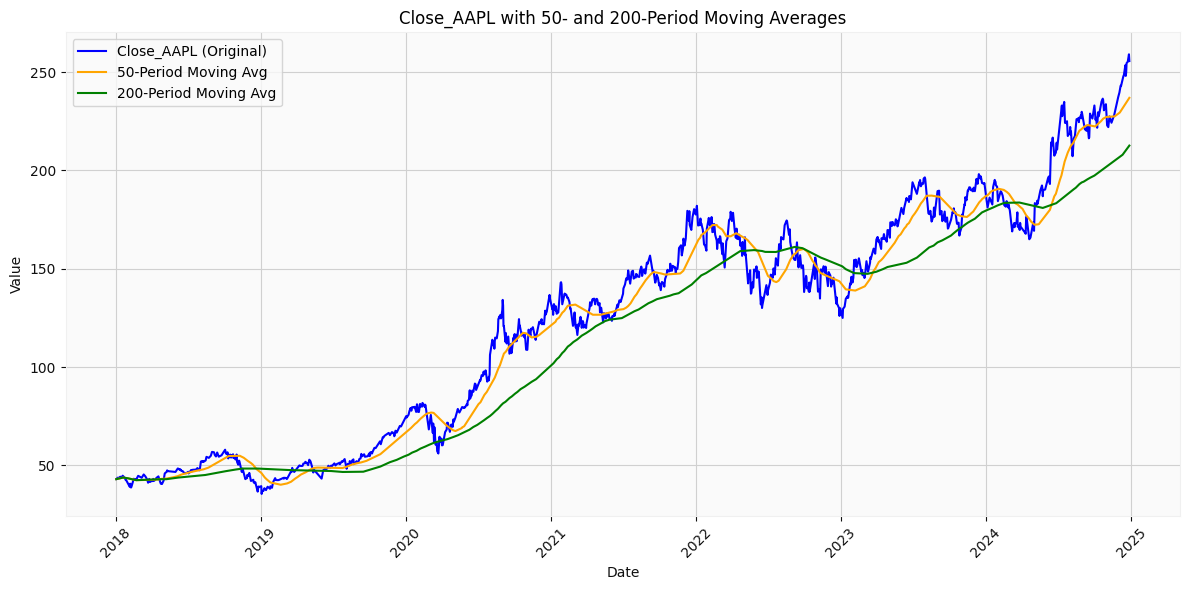

In [40]:
def plot_two_moving_averages(spark_df, column_name, num_periods_1, num_periods_2):
    # Define the moving average column names
    moving_avg_col_1 = f"{column_name}_Moving_Avg_{num_periods_1}"
    moving_avg_col_2 = f"{column_name}_Moving_Avg_{num_periods_2}"

    # Convert Spark DataFrame to Pandas for plotting
    pandas_df = spark_df.select(["Date", column_name, moving_avg_col_1, moving_avg_col_2]).toPandas()

    # Ensure 'Date' column is in datetime format for proper plotting
    pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])

    # Plot the original data and moving averages
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=pandas_df, x="Date", y=column_name, label=f"{column_name} (Original)", color="blue")
    sns.lineplot(data=pandas_df, x="Date", y=moving_avg_col_1, label=f"{num_periods_1}-Period Moving Avg", color="orange")
    sns.lineplot(data=pandas_df, x="Date", y=moving_avg_col_2, label=f"{num_periods_2}-Period Moving Avg", color="green")

    # Add titles and labels
    plt.title(f"{column_name} with {num_periods_1}- and {num_periods_2}-Period Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_two_moving_averages(mv_avg, choosed_col, number_of_periods_1, number_of_periods_2)

After plotting the curves, we can proceed with the analysis. The **Death Cross** occurs when the 200-day moving average (MA-200) crosses above the 50-day moving average (MA-50), signaling a potential bearish trend. In 2019, we observe that this crossover took place, and Apple’s stock subsequently experienced a decline.

Approximately six months later, the **Golden Cross** occurred, when the MA-50 crossed above the MA-200. This is a widely recognized bullish signal, often indicating the start of an upward trend. Following the Golden Cross, Apple’s stock surged, reflecting strong investor confidence and market optimism.

The **Death Cross** can often be a signal to sell or reduce exposure to the stock, as it suggests a potential downward trend. Investors may choose to exit positions or avoid new purchases until the trend shows signs of reversing.

Conversely, the **Golden Cross** is seen as a buy signal, especially when accompanied by strong trading volume, suggesting upward momentum. Investors often use this signal to enter the stock, expecting price increases.
The Death Cross followed by the Golden Cross in 2019-2020 illustrates how moving averages can be key indicators for market trends.

Investors can use these crossovers to identify potential entry or exit points. For instance, the Golden Cross was a strong signal to buy Apple stock, which later delivered significant returns.

Additionally, another Golden Cross occurred in March 2023, followed by another one in June 2024, further confirming positive market sentiment during those periods.

Source:  https://academy.youngplatform.com/fr/trading/moyennes-mobiles-golden-cross-death-cross/


## The Importance of Portfolio Diversification

In this insight, we will explore the importance of portfolio diversification by analyzing the correlation between the stock prices of two companies.

RadioButtons(description='Sélectionner 1ère entreprise:', options=('AAPL', 'MSFT', 'AMZN', 'META', 'ZM'), valu…

RadioButtons(description='Sélectionner 2ème entreprise:', index=1, options=('AAPL', 'MSFT', 'AMZN', 'META', 'Z…

Symboles sélectionnés : ['AAPL', 'MSFT']
The correlation between Close_AAPL and Close_MSFT daily returns is: 0.9869554003782129
Corrélation calculée entre AAPL et MSFT: 0.99
Affichage des courbes pour AAPL et MSFT...


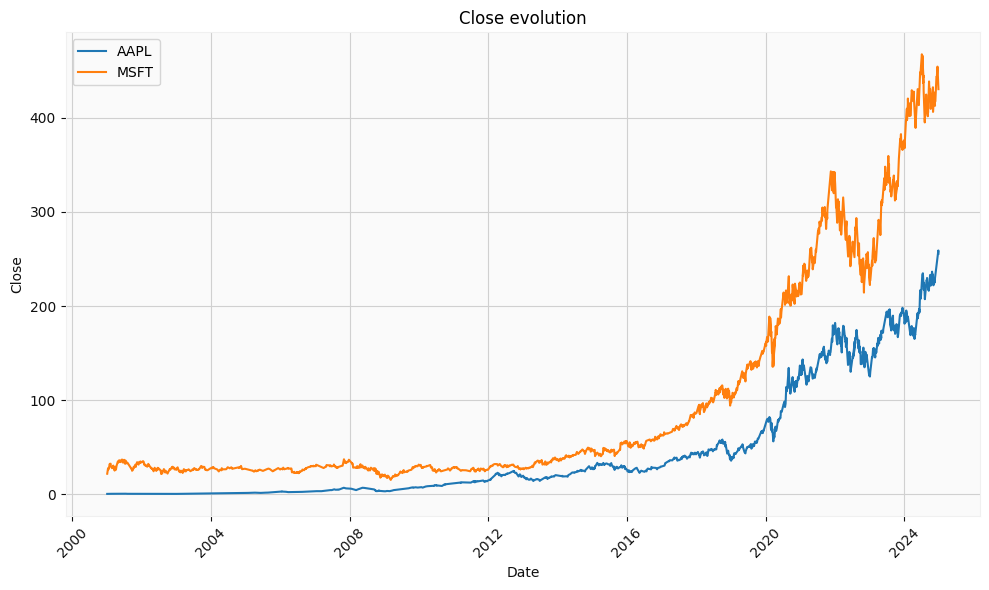

In [41]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Création des widgets pour la sélection des actions
selected_symbol_1 = widgets.RadioButtons(
    options=symbols,
    description="Sélectionner 1ère entreprise:",
    disabled=False
)

# Filtrer les options restantes pour la deuxième sélection
selected_symbol_2 = widgets.RadioButtons(
    options=symbols,
    description="Sélectionner 2ème entreprise:",
    disabled=False
)

# Fonction pour mettre à jour les symboles sélectionnés et calculer la corrélation
def update_selected_symbols(change):
    # Effacer uniquement la sortie précédente (pas les widgets)
    clear_output(wait=True)

    # Afficher les widgets à nouveau au sommet
    display(selected_symbol_1, selected_symbol_2)

    selected_symbols = [selected_symbol_1.value, selected_symbol_2.value]

    # Affichage des symboles sélectionnés
    print(f"Symboles sélectionnés : {selected_symbols}")

    # Calcul de la corrélation entre les prix de clôture des deux actions sélectionnées
    correlation = calculate_correlation(spark_df, f"Close_{selected_symbols[0]}", f"Close_{selected_symbols[1]}")
    print(f"Corrélation calculée entre {selected_symbols[0]} et {selected_symbols[1]}: {correlation:.2f}")

    # Remplacer l'affichage précédent par la courbe et la corrélation
    print(f"Affichage des courbes pour {selected_symbols[0]} et {selected_symbols[1]}...")

    # Tracer les courbes pour les actions sélectionnées
    plot_col("Close", spark_df, selected_symbols)

# Observer les changements dans les widgets pour mettre à jour la deuxième option et recalculer la corrélation
selected_symbol_1.observe(update_selected_symbols, names="value")
selected_symbol_2.observe(update_selected_symbols, names="value")

# Afficher les widgets pour la sélection des actions
display(selected_symbol_1, selected_symbol_2)

 # Analyse en fonction de la corrélation
if correlation <= 0.5 and correlation >= -0.5:
    print("Investing in these two companies could be interesting because if one company is in decline, the other is not affected.")
else:
    print("These companies are too correlated, which makes them less interesting for portfolio diversification.")


In our study, we only focus on NASDAQ tech stocks. However, if an investor wants to diversify their portfolio, they should consider changing sectors entirely.

## Identifying the Most Resilient Stocks During a Crisis

In this insight, we will analyze how different companies performed during the 2022 crisis triggered by the war in Ukraine. Our focus will be on identifying the companies that experienced the least decline, highlighting those that demonstrated resilience during a period of global uncertainty. This analysis aims to help investors pinpoint stocks that are more stable in times of crisis.

In [42]:
spark_df_crisis = spark_df.filter(col("Date") > "2022-01-01")
spark_df_crisis = spark_df_crisis.filter(col("Date") < "2023-01-01")
panda_df_crisis = spark_df_crisis.toPandas()
panda_df_crisis['Date'] = pd.to_datetime(panda_df_crisis['Date'])


In [43]:
# Création de la figure
fig = go.Figure()

# Ajouter les traces pour chaque symbole
for symbol in symbols:
    column_name = f"Close_{symbol}"
    if column_name in panda_df_crisis.columns:
        fig.add_trace(go.Scatter(
            x=panda_df_crisis['Date'],
            y=panda_df_crisis[column_name],
            mode='lines',
            name=symbol,
            line=dict(width=2)
        ))

# Mise en page du graphique
fig.update_layout(
    title="Closing Price evolution after the crisis",
    xaxis_title="Years",
    yaxis_title="Closing Price",
    template='plotly_white',
    legend=dict(
        title="Legend",
        orientation="h",
        x=0.5,
        xanchor="center",
        y=-0.2
    )
)

# Affichage du graphique dans le notebook
fig.show()

In [44]:
close_columns = [col for col in panda_df_crisis.columns if col.startswith('Close_')]

percentage_changes = {}
for col in close_columns:
    first_value = panda_df_crisis[col].iloc[0]  # First
    last_value = panda_df_crisis[col].iloc[-1]  # Last
    percentage_change = ((last_value - first_value) / first_value) * 100
    percentage_changes[col] = percentage_change

Here is the evolution of the closing prices for each stock since the crisis:

In [45]:

for col, change in percentage_changes.items():
    symbol = col.split('_')[1]  # Extract the stock symbol
    if change > 0:
        print(f"The closing price change for {symbol} is {change:.2f}%. This indicates an increase in price.")
    elif change < 0:
        print(f"The closing price change for {symbol} is {change:.2f}%. This indicates a decrease in price.")
    else:
        print(f"The closing price change for {symbol} is 0%. The price has remained stable.")


The closing price change for AAPL is -28.61%. This indicates a decrease in price.
The closing price change for AMZN is -50.71%. This indicates a decrease in price.
The closing price change for META is -64.45%. This indicates a decrease in price.
The closing price change for MSFT is -28.36%. This indicates a decrease in price.
The closing price change for ZM is -63.24%. This indicates a decrease in price.


This data suggests that Apple and Microsoft have been more resilient during the crisis, experiencing less of a drop in their stock prices compared to other major tech companies like Meta and Zoom. Investors may find these two stocks less volatile and potentially more stable options during periods of economic uncertainty.


## Understanding Stock Volatility

In this insight, we will analyze stock volatility, which refers to the variation in prices over time. By observing volatility, we can better understand the risks associated with each stock and adjust our investment strategy based on the fluctuations observed.

Next, we'll select a month to analyze which company has the highest volatility during that period.


In [46]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Chargement du fichier CSV
pandas = pd.read_csv("cleaned_df.csv")
pandas['Date'] = pd.to_datetime(pandas['Date'])

# Filtrer les données pour les années >= 2020
pandas = pandas[pandas['Date'].dt.year >= 2020]

# Extraire le mois et l'année pour créer une nouvelle colonne Month_Year
pandas['Month_Year'] = pandas['Date'].dt.to_period('M')

# Extraire la liste des mois uniques (comme 'YYYY-MM')
months = pandas['Month_Year'].dt.strftime('%Y-%m').unique()  # Convertir en string format 'YYYY-MM'

# Fonction pour afficher la volatilité en fonction du mois sélectionné
def show_volatility(selected_month):
    # Filtrer les données pour le mois sélectionné
    filtered_df = pandas[pandas['Month_Year'].dt.strftime('%Y-%m') == selected_month]

    # Calcul de la volatilité
    volatility_columns = [col for col in filtered_df.columns if col.startswith('High_')]
    volatility = {}

    for col in volatility_columns:
        symbol = col.split('_')[1]
        high_col = f'High_{symbol}'
        low_col = f'Low_{symbol}'
        volatility[symbol] = (filtered_df[high_col] - filtered_df[low_col]).mean()

    # Affichage des résultats de volatilité
    print(f"Volatility for the month {selected_month}:")
    for symbol, vol in volatility.items():
        print(f"{symbol}: {vol:.2f}")

    # Tracer un graphique en barres pour afficher la volatilité
    symbols = list(volatility.keys())
    values = list(volatility.values())

    plt.figure(figsize=(10, 6))
    plt.bar(symbols, values, color='skyblue')
    plt.xlabel('Stock Symbols')
    plt.ylabel('Volatility')
    plt.title(f'Volatility for {selected_month}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Créer un curseur pour sélectionner le mois (format 'YYYY-MM')
month_selector = widgets.SelectionSlider(
    options=months,  # Mois sous forme de chaîne 'YYYY-MM'
    value=months[0],  # Mois par défaut
    description='Select Month:',
    continuous_update=False
)

# Lier le curseur à la fonction de calcul et d'affichage
interactive_plot = interactive(show_volatility, selected_month=month_selector)

# Afficher le curseur et l'interactivité
display(interactive_plot)


interactive(children=(SelectionSlider(continuous_update=False, description='Select Month:', options=('2020-01'…

After selecting several months, we observe that META is highly volatile, which can represent significant risks for investors but also large potential gains if managed well. On the other hand, companies like Apple and Microsoft are more stable, leading to lower risk.


## Identifying the Best and Worst Months for Investment

In [47]:
panda = pd.read_csv("monthly_change.csv")

In this insight, we analyze the average monthly changes in stock prices to determine which months are best for investing and which should be avoided.

Average Monthly Changes in Stock Prices by Month

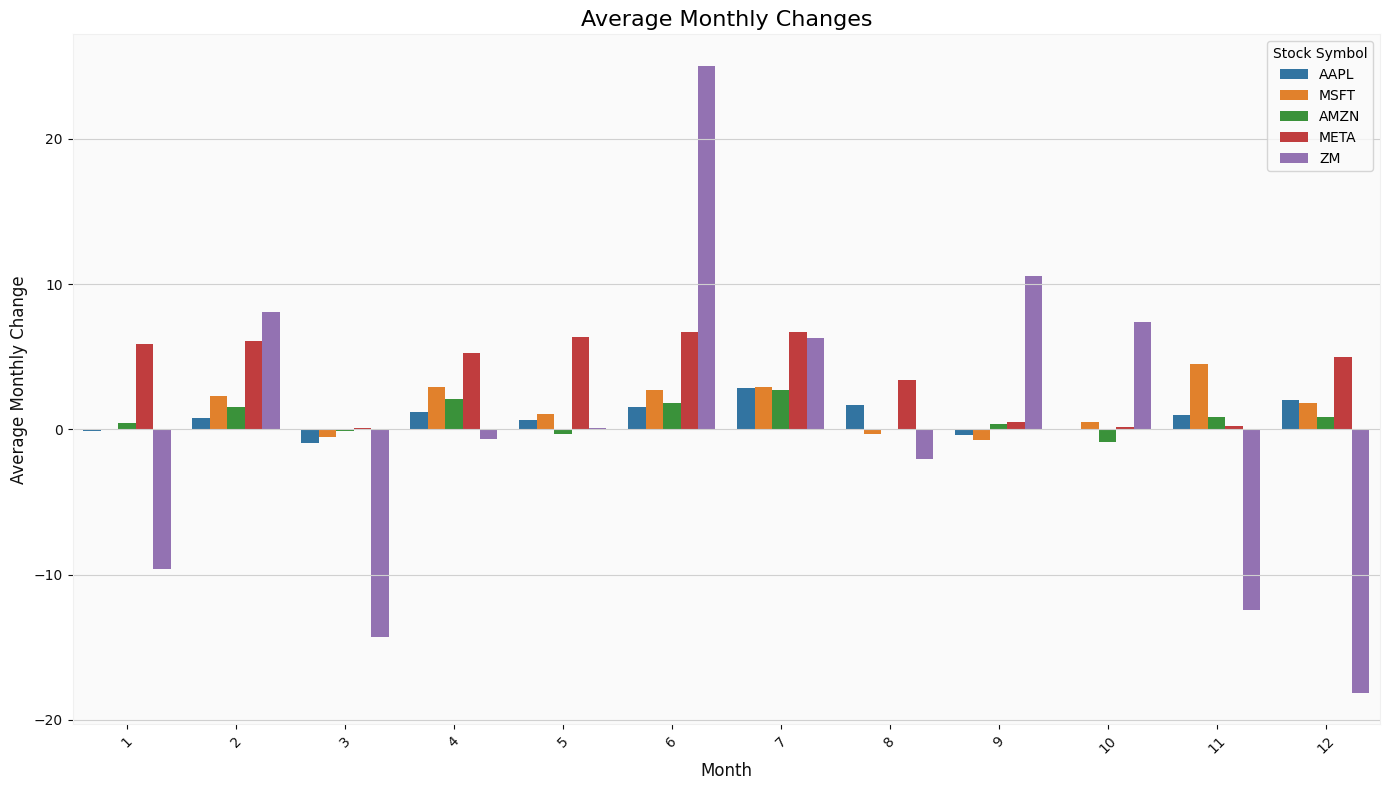

In [48]:
# Filtrer uniquement les colonnes contenant les changements mensuels
change_columns = [col for col in panda.columns if col.startswith("Monthly_Change")]

# Calculer la moyenne des changements mensuels pour chaque mois
pf = panda.groupby(['Month'])[change_columns].mean().reset_index()

# Transformer les données en format long pour Seaborn
long_pf = pf.melt(id_vars='Month', var_name='Stock', value_name='Monthly Change')

# Extraire uniquement le symbole de l'action (ex: 'AAPL', 'MSFT')
long_pf['Stock'] = long_pf['Stock'].str.split('_').str[-1]

# Tracer un graphique en barres côte à côte
plt.figure(figsize=(14, 8))
sns.barplot(data=long_pf, x='Month', y='Monthly Change', hue='Stock', palette='tab10')

# Personnalisation du graphique
plt.title("Average Monthly Changes", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Monthly Change", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Stock Symbol", fontsize=10, loc='upper right')
plt.tight_layout()

# Afficher le graphique
plt.show()

Based on the graphical analysis of the monthly changes, it is clear that March, September, and October generally show negative changes compared to the previous months. Investors may want to avoid investing during these months, as they tend to experience declines. On the other hand, February, April, July, and August often show positive monthly changes, indicating these months may offer better opportunities for investment.


## How Bollinger Bands Can Signal Market Opportunities

In [49]:
panda_mv = pd.read_csv("mv_avg_20.csv")

In this insight, we will explore Bollinger Bands, a popular technical analysis tool used to measure the volatility of a stock. Bollinger Bands consist of three lines: the simple moving average (SMA) in the center, the upper band, and the lower band. The upper and lower bands are typically set two standard deviations away from the SMA, and they adjust based on the stock's volatility.


In [50]:
panda_mv['Date'] = pd.to_datetime(panda_mv['Date'])
panda_mv.set_index('Date', inplace=True)
start_date = '2020-01-01'
end_date = '2025-01-01'
panda_mv = panda_mv.loc[(panda_mv.index >= pd.to_datetime(start_date)) & (panda_mv.index <= pd.to_datetime(end_date))]


In [51]:
# Widgets pour sélectionner une entreprise et les dates de début et de fin
selection_widget = widgets.RadioButtons(
    options=symbols,
    description="Select a Company:",
    style={'description_width': 'initial'}
)

start_date_widget = widgets.DatePicker(description='Start Date', value=panda_mv.index.min())
end_date_widget = widgets.DatePicker(description='End Date', value=panda_mv.index.max())

# Fonction de mise à jour du graphique
def update_plot(selection, start_date, end_date):
    # Filtrer les données entre start_date et end_date
    filtered_data = panda_mv.loc[(panda_mv.index >= pd.to_datetime(start_date)) &
                                 (panda_mv.index <= pd.to_datetime(end_date))]

    # Calcul des bandes de Bollinger
    filtered_data["Upper_Band"] = filtered_data[f"Close_{selection}_Moving_Avg_20"] + \
                                   2 * filtered_data[f"Close_{selection}"].rolling(window=20).std()
    filtered_data["Lower_Band"] = filtered_data[f"Close_{selection}_Moving_Avg_20"] - \
                                   2 * filtered_data[f"Close_{selection}"].rolling(window=20).std()

    # Création du graphique
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(filtered_data[f'Close_{selection}'], label='Closing Price', color='blue', alpha=0.6)
    ax.plot(filtered_data[f'Close_{selection}_Moving_Avg_20'], label='MA 20 days', color='red')
    ax.plot(filtered_data["Upper_Band"], label='Upper Band', color='green', linestyle='--')
    ax.plot(filtered_data["Lower_Band"], label='Lower Band', color='green', linestyle='--')

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.set_title(f"Bollinger Bands for {selection}")

    plt.show()
    if selection == "AAPL":
        print("The Bollinger Bands show high volatility since mid-2024, with a strong upward trend from September 2024.")
        print("\n")
        print("Investor Tips: The trend is strong, but being close to the upper band may indicate a possible correction.")
        print("\n")
    elif selection == "MSFT":
        print("The Bollinger Bands show several cycles of volatility in 2024, with periods of contraction followed by sharp expansions.")
        print("\n")
        print("Investor Tips: Cyclical volatility requires close monitoring of band contractions.")
        print("\n")
    elif selection == "AMZN":
        print("The Bollinger Bands show a gradual price increase in 2024, with consolidation phases around the moving average.")
        print("\n")
        print("Investor Tips: The upward trend is strong, but prices near the upper band suggest a potential overbought condition.")
        print("\n")
    elif selection == "META":
        print("META's price frequently hovered around the moving average, suggesting periods of market indecision and consolidation.")
        print("\n")
        print("Investor Tips: The sustained upward trend suggests potential for further growth.")
        print("\n")
    elif selection == "ZM":
        print("The Bollinger Bands show a significant decline in the first half of 2024, followed by a sharp recovery starting mid-year.")
        print("\n")
        print("Investor Tips: The sharp upward trend after mid-2024 signals a strong recovery phase.")
        print("\n")

    # Explications générales
    print("When the stock price touches or exceeds the upper band, it often precedes a price decline or consolidation, suggesting overbought conditions.")
    print("\n")
    print("Conversely, when the price approaches or dips below the lower band, it often signals oversold conditions, leading to a potential rebound or upward movement.")

# Lier les widgets à la fonction
interactive_plot = widgets.interactive(
    update_plot,
    selection=selection_widget,
    start_date=start_date_widget,
    end_date=end_date_widget
)

# Afficher les widgets et l'interactivité
display(interactive_plot)

interactive(children=(RadioButtons(description='Select a Company:', options=('AAPL', 'MSFT', 'AMZN', 'META', '…

# Conclusion

A good understanding of stock trends and data visualization is crucial for making informed investment decisions. Throughout this analysis, we observed that Apple is a strong long-term investment, with consistent growth and resilience, making it a favorable option for investors looking for stability over time.


Understanding phenomena like the Golden Cross and Death Cross can be extremely useful in identifying potential buying or selling opportunities, as these patterns signal important shifts in market trends. Recognizing these signals can help investors make timely decisions, optimizing their returns.


Diversification is also a key strategy, especially during times of crisis. By holding a mix of assets, investors can protect their portfolios from significant losses in case one company underperforms, ensuring better overall stability.


For those interested in short-term investments, analyzing volatility and knowing which months typically offer better performance can be advantageous. Utilizing tools like Bollinger Bands can further help by indicating potential overbought or oversold conditions, guiding investors on when to enter or exit the market.


Ultimately, a combination of long-term strategies, a well-diversified portfolio, and short-term market analysis can provide a balanced approach to navigating the complexities of investing in the stock market.